# Проект: "Промышленность"

**Описание проекта:**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Для этого необходимо построить модель, которая будет её предсказывать. В свою очередь заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Цель проекта:**

Необходимо построить модель, которая будет предсказывать температуру сплава. По условию от заказчика:
1. Целевой признак: последняя измеренная температура.
2. Метрика оценки качества: МАЕ (не выше 6.8).

**Описание данных для проекта:**

Заказчиком предоставлены данные, которые состоят из нескольких файлов, полученных из разных источников:
1. data_arc_new.csv — данные об электродах;
2. data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
3. data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
4. data_gas_new.csv — данные о продувке сплава газом;
5. data_temp_new.csv — результаты измерения температуры;
6. data_wire_new.csv — данные о проволочных материалах (объём);
7. data_wire_time_new.csv — данные о проволочных материалах (время).

Для файла **data_arc_new.csv**:
- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

Для файла **data_bulk_new.csv**:
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

Для файла **data_bulk_time_new.csv**:
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

Для файла **data_gas_new.csv**:
- key — номер партии;
- Газ 1 — объём подаваемого газа.

Для файла **data_temp_new.csv**:
- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

Для файла **data_wire_new.csv**:
- key — номер партии;
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

Для файла **data_wire_time_new.csv**:
- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

**Примечание к файлам с данными:** Во всех файлах столбец *key* содержит номер партии. В файлах может быть несколько строк с одинаковым значением *key*: они соответствуют разным итерациям обработки.

**План работы с проектом:**
1. Загрузка и изучение данных;
2. Исследовательский анализ и предобработка данных;
3. Объединение данных;
4. Исследовательский анализ и предобработка данных объединённого датафрейма;
5. Подготовка данных;
6. Обучение моделей машинного обучения;
7. Выбор лучшей модели и проверка её качества на тестовой выборке;
8. Формирование общего вывода и рекомендаций для заказчика.

## Загрузка и изучение данных

In [168]:
# установим, необходимую библиотеку
!pip install catboost

In [169]:
# установим необходимую библиотеку
!pip install lightgbm

In [170]:
!pip install shap

In [171]:
# загрузим стандартные библиотеки, необходимые для работы
import pandas as pd
import math
import sklearn
import numpy as np
from scipy import stats as st

# загрузим библиотеки для визуализации данных
import matplotlib.pyplot as plt 
import seaborn as sns
import shap

# загрузим модули, необходимые для работы
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import time
import warnings
warnings.filterwarnings('ignore')

# зададим константу
RANDOM_STATE = 250825

### Файл 'data_arc_new.csv': данные об электродах

In [172]:
# загрузим данные из файла 'data_arc_new.csv' 
try:
    # локальный путь к файлу
    data_arc_new = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ВП/data_arc_new.csv')
except:
    # путь к файлу в тренажере
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')

# посмотрим первые 5 строк датафрема
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [173]:
# посмотрим общую информацию о данных
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, пропуски отсутствуют. Названия столбцов необходимо привести к общепринятому "змеиному" стилю, а также изменить тип данных в столбцах 'Начало нагрева дугой' и 'Конец нагрева дугой' на 'datetime' (сейчас указан некорректный тип данных). Первично можем заметить, что некоторые партии нагревают по несколько раз.

### Файл 'data_bulk_new.csv': данные о подаче сыпучих материалов (объём)

In [174]:
# загрузим данные из файла 'data_bulk_new.csv' 
try:
    # локальный путь к файлу
    data_bulk_new = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ВП/data_bulk_new.csv')
except:
    # путь к файлу в тренажере
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')

# посмотрим первые 5 строк датафрема
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [175]:
# посмотрим общую информацию о данных
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, в каждом столбце с объемом подаваемого материала присутствуют пропуски. Названия столбцов необходимо привести к общепринятому "змеиному" стилю, тип данных во всех столбцах корректный. Также можем заметить, что у нас присутствует достаточно много пропущенных значений, однако, это те пропуски, когда во время производства материал не подавался, соответственно, это естественный процесс производства, а значит, что все присутствующие пропуски можно заметить на ноль.

### Файл 'data_bulk_time_new.csv': данные о подаче сыпучих материалов (время)

In [176]:
# загрузим данные из файла 'data_bulk_time_new.csv' 
try:
    # локальный путь к файлу
    data_bulk_time_new = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ВП/data_bulk_time_new.csv')
except:
    # путь к файлу в тренажере
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')

# посмотрим первые 5 строк датафрема
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [177]:
# посмотрим общую информацию о данных
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, в каждом столбце со временем подаваемого материала присутствуют пропуски. Названия столбцов необходимо привести к общепринятому "змеиному" стилю, а тип данных привести к 'datetime' во всех столбцах, кроме 'key'. Данный датасет имеет только информации о времени подачи материалов, что по сути не оказывает сильного значения на исследование, поэтому, скорее всего не будем его использовать для решения поставленной задачи.

### Файл 'data_gas_new.csv': данные о продувке сплава газом

In [178]:
# загрузим данные из файла 'data_gas_new.csv' 
try:
    # локальный путь к файлу
    data_gas_new = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ВП/data_gas_new.csv')
except:
    # путь к файлу в тренажере
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')

# посмотрим первые 5 строк датафрема
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [179]:
# посмотрим общую информацию о данных
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, пропуски отсутствуют. Названия столбцов необходимо привести к общепринятому "змеиному" стилю, тип данных во всех столбцах корректный.

### Файл 'data_temp_new.csv': результаты измерения температуры

In [180]:
# загрузим данные из файла 'data_temp_new.csv' 
try:
    # локальный путь к файлу
    data_temp_new = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ВП/data_temp_new.csv')
except:
    # путь к файлу в тренажере
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')

# посмотрим первые 5 строк датафрема
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [181]:
# посмотрим общую информацию о данных
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, присутствуют пропуски в столбце 'Температура'. Названия столбцов необходимо привести к общепринятому "змеиному" стилю, необходимо поменять тип данных в столбце 'Время замера' на 'datetime'.

### Файл 'data_wire_new.csv': данные о проволочных материалах (объём)

In [182]:
# загрузим данные из файла 'data_wire_new.csv' 
try:
    # локальный путь к файлу
    data_wire_new = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ВП/data_wire_new.csv')
except:
    # путь к файлу в тренажере
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')

# посмотрим первые 5 строк датафрема
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
# посмотрим общую информацию о данных
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, в каждом столбце с объемом проволочных материалов присутствуют пропуски. Названия столбцов необходимо привести к общепринятому "змеиному" стилю, тип данных во всех столбцах корректный. Также можем заметить, что у нас присутствует достаточно много пропущенных значений, однако, это те пропуски, когда во время производства проволочный материал не подавался, соответственно, это естественный процесс производства, а значит, что все присутствующие пропуски можно заметить на ноль.

### Файл 'data_wire_time_new.csv': данные о проволочных материалах (время)

In [184]:
# загрузим данные из файла 'data_wire_time_new.csv' 
try:
    # локальный путь к файлу
    data_wire_time_new = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ВП/data_wire_time_new.csv')
except:
    # путь к файлу в тренажере
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

# посмотрим первые 5 строк датафрема
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
# посмотрим общую информацию о данных
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, в каждом столбце со временем проволочного материала присутствуют пропуски. Названия столбцов необходимо привести к общепринятому "змеиному" стилю, а тип данных привести к 'datetime' во всех столбцах, кроме 'key'. Данный датасет имеет только информации о времени проволочных материалов, что по сути не оказывает сильного значения на исследование, поэтому, скорее всего не будем его использовать для решения поставленной задачи.

**Обобщающий вывод этапа "Загрузка и изучение данных":**
1. Данные во всех семи таблицах соответствую описанию задачи.
2. В пяти из семитаблицах с данными в столбцах присутствуют пропуски, некоторые из которых необходимо обработать. Также в некоторых таблицах необходимо изменить тип данных некоторых столбцов.
3. Во всех таблицах необходимо привести названия столбцов к общепринятому "змеиному" стилю.
4. Также стоит отметить, что при первичном изучении данных было выяснено, что таблицы 'data_bulk_time_new' и 'data_wire_time_new' содержать информацию о времени подачи различных видов материалов. Эти данные не имеют ценности для дальнейшего анализа. Поэтому уже на первом этапе эти таблицы с данными будут отброшены и не будут использоваться при дальнейшей обработке и реализации проекта, что в том числе сократит время выполнения задачи.

## Исследовательский анализ и предобработка данных

На данном этапе будут рассмотрены и обработаны следующие пять таблицы с данными:
1. data_arc_new — данные об электродах;
2. data_bulk_new — данные о подаче сыпучих материалов (объём);
3. data_gas_new — данные о продувке сплава газом;
4. data_temp_new — результаты измерения температуры;
5. data_wire_new — данные о проволочных материалах (объём);

Две таблицы 'data_bulk_time_new — данные о подаче сыпучих материалов (время)' и 'data_wire_time_new — данные о проволочных материалах (время)' на следующих этапах участвовать не будут, т.к. были откинуты с точки зрения неинформативности для реализации задачи.

### Исследовательский анализ и предобработка данных таблицы 'data_arc_new'

In [186]:
# снова посмотрим первые 5 строк таблицы
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [187]:
# для начала изменим названия столбцов, приведя их к общепринятому стилю
data_arc_new = data_arc_new.rename(columns={
    'Начало нагрева дугой' : 'beginning_of_arc',
    'Конец нагрева дугой' : 'end_of_arc',
    'Активная мощность' : 'active_power',
    'Реактивная мощность' : 'reactive_power'
})

In [188]:
# посмотрим названия столбцов после изменения
data_arc_new.head()

,key,beginning_of_arc,end_of_arc,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [189]:
# посмотрим информацию о таблице
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               14876 non-null  int64  
 1   beginning_of_arc  14876 non-null  object 
 2   end_of_arc        14876 non-null  object 
 3   active_power      14876 non-null  float64
 4   reactive_power    14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [190]:
# столбцы 'beginning_of_arc' и 'end_of_arc' имеют неправильный тип данных, необходимо заменить на 'datetime'
data_arc_new['beginning_of_arc'] = pd.to_datetime(data_arc_new['beginning_of_arc'])
data_arc_new['end_of_arc'] = pd.to_datetime(data_arc_new['end_of_arc'])

In [191]:
# посмотрим общую информацию о таблице после изменений
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14876 non-null  int64         
 1   beginning_of_arc  14876 non-null  datetime64[ns]
 2   end_of_arc        14876 non-null  datetime64[ns]
 3   active_power      14876 non-null  float64       
 4   reactive_power    14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [192]:
# посмотрим количество пропусков в данных
data_arc_new.isna().sum()

key                 0
beginning_of_arc    0
end_of_arc          0
active_power        0
reactive_power      0
dtype: int64

**Примечание:** Пропуски в данных полностью отсутствуют.

In [193]:
# проверим датафрейм на наличие явных дубликатов
data_arc_new.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутствуют.

In [194]:
# проведем статистический анализ количественных признаков
print('Описательная статистика для количественных признаков:')
data_arc_new.describe(include=[np.number])

Описательная статистика для количественных признаков:


,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [195]:
# напишем собственную функцию для визуализации количественных признаков
def numeric(data, column, title):
    # устанавливаем параметры графика
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
    
    # построение гистограммы для количественных признаков 
    sns.histplot(data, x=column, bins=20, kde=True, ax=ax1, color='lightpink')
    ax1.set_title(f'Гистограмма для {column}')
    ax1.set_xlabel(f'Значения столбца {column}')
    ax1.set_ylabel('Частота')
    
    # построение графика "Ящик с усами"
    sns.boxplot(data=data, x=column, ax=ax2, color='lightblue')
    ax2.set_title(f'Ящик с усами для {column}')
    ax2.set_xlabel(column)
    
    # окончательная настройка графика
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

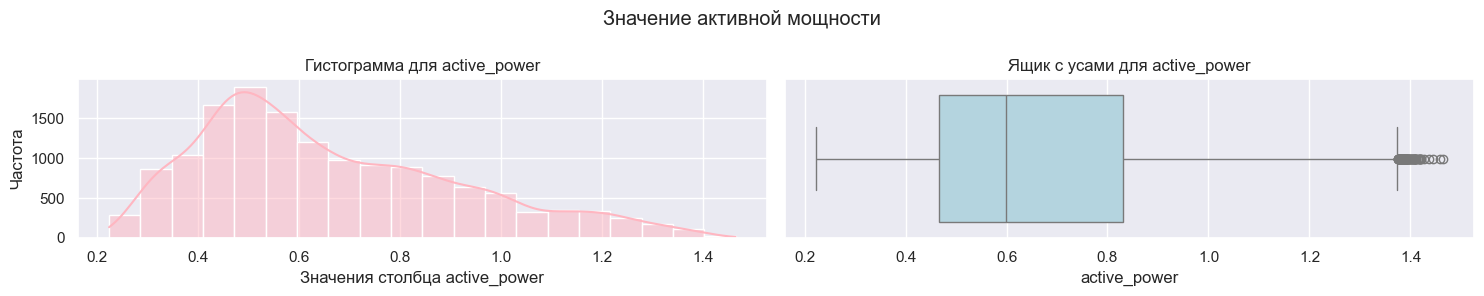

In [196]:
# визуализация признака 'active_power'
numeric(data_arc_new, 'active_power', 'Значение активной мощности')

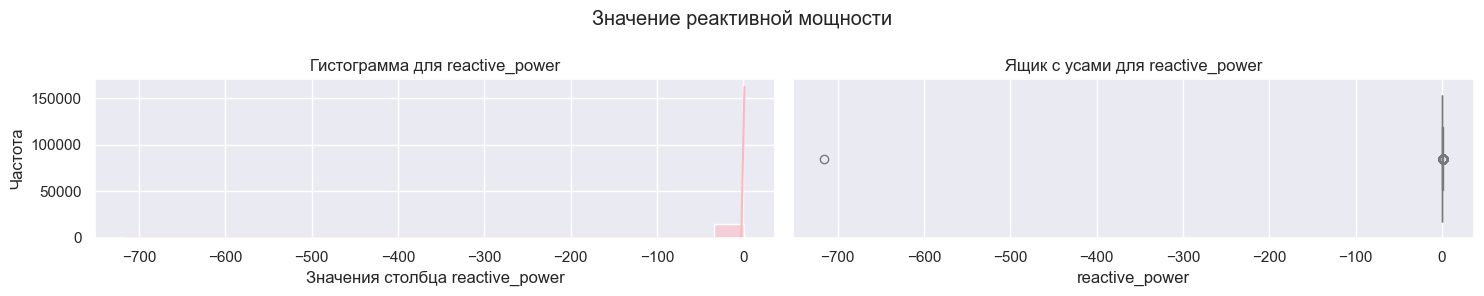

In [197]:
# визуализация признака 'reactive_power'
numeric(data_arc_new, 'reactive_power', 'Значение реактивной мощности')

**Примечание:**
1. По результатам визализации признака 'active_power' заметно небольшое смещение графика влево.
2. По результатам визуализации признака 'reactive_power' на графике "Ящик с усами" виден один большой аномально отрицательный выброс. Данный выброс стоит обработать.

In [198]:
# посмотрим на значения строки с аномальным отрицательным значением признака 'reactive_power'
data_arc_new[data_arc_new['reactive_power'] < 0]

,key,beginning_of_arc,end_of_arc,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [199]:
# данный выброс один, его стоит обработать, поэтому удалим строку с аномальным значением по значения столбца 'key'
data_arc_new = data_arc_new[data_arc_new['key'] != 2116]

In [200]:
# посмотрим общую информацию о таблице после удаления
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14872 non-null  int64         
 1   beginning_of_arc  14872 non-null  datetime64[ns]
 2   end_of_arc        14872 non-null  datetime64[ns]
 3   active_power      14872 non-null  float64       
 4   reactive_power    14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


**Примечание:** Удаление произведено корректно, без изменения остальных данных.

In [201]:
# для того чтобы определить общие затраты электроэнергии на нагрев стали рассчитаем полную мощность
# полная можность = кв. кор. (активная мощность ^2 + реактивная мозность ^2)
data_arc_new['power'] = ((data_arc_new['active_power']) ** 2 + (data_arc_new['reactive_power']) ** 2) ** 0.5

# сразу посмотрим первые 5 строк таблицы с новым признаком
data_arc_new.head()

,key,beginning_of_arc,end_of_arc,active_power,reactive_power,power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


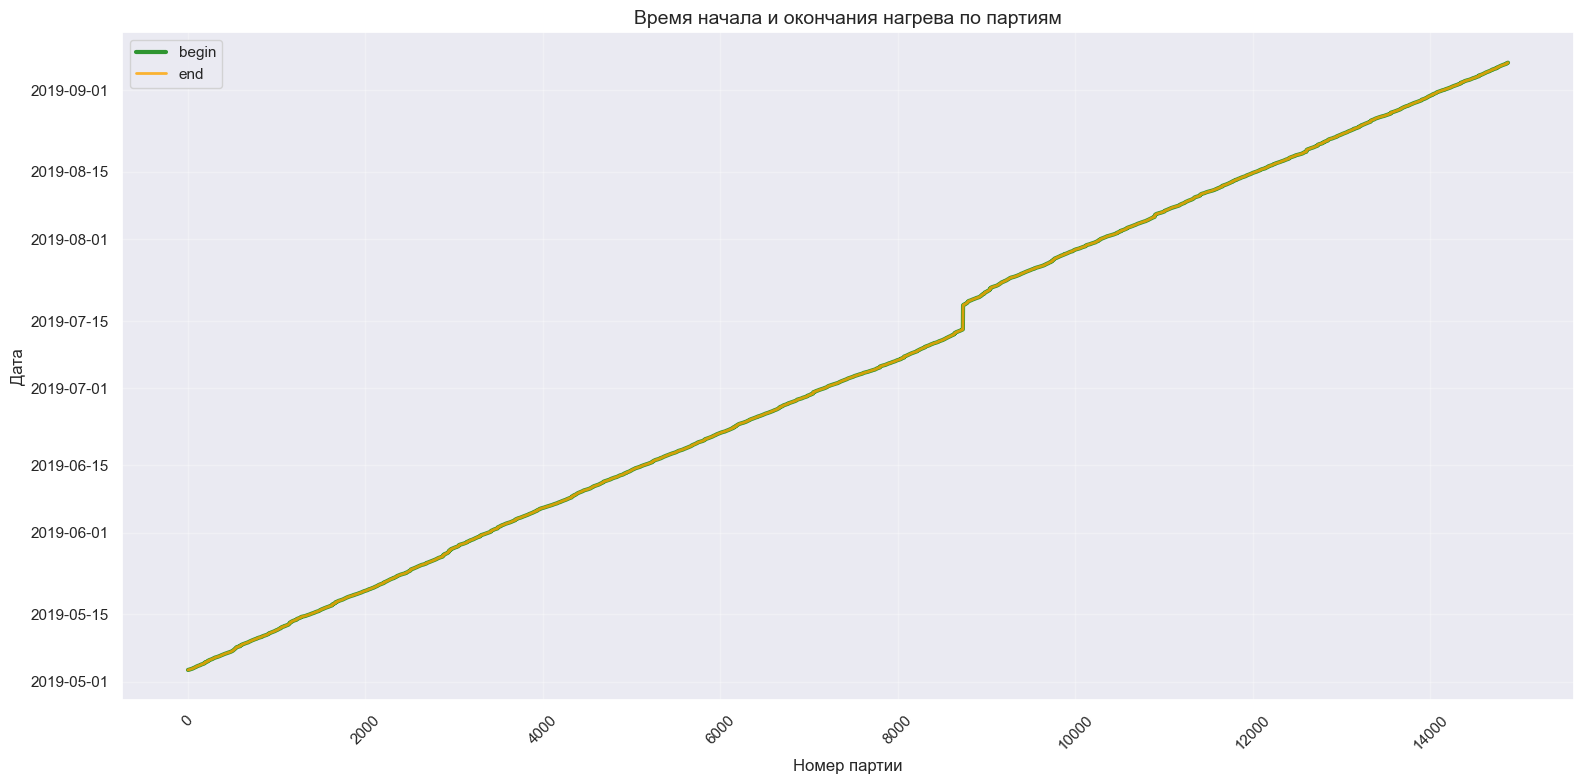

In [202]:
# визуализируем признаки начала и окончания времени нагрева
plt.figure(figsize=(16, 8))  

ax = data_arc_new['beginning_of_arc'].plot(label='begin', linewidth=3.0, color='green', alpha=0.8)
ax = data_arc_new['end_of_arc'].plot(label='end', linewidth=2.0, color='orange', alpha=0.8)

ax.set_xlabel('Номер партии', fontsize=12)
ax.set_ylabel('Дата', fontsize=12)
ax.set_title('Время начала и окончания нагрева по партиям', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

**Примечание:** Время начала и окончания нагрева не сильно важно для исследования, но общее затраченное время может понадобиться для итогового расчета температуры, поэтому рассчитаем его на всякий случай. Если посмотреть на значения таблицы, то в целом время нагрева варьируется от 2 до 6 минут и определенного количества секунд, поэтому стоит рассчитать время в секундах, чтобы учесть всю продолжительность.

In [203]:
# рассчитаем интервал между началом и окончанием нагрева в секундах
data_arc_new['time_interval'] = data_arc_new['end_of_arc'] - data_arc_new['beginning_of_arc']
data_arc_new['time_interval'] = data_arc_new['time_interval'].dt.total_seconds()

In [204]:
# посмотрим первые 5 строк таблицы с новым признаком
data_arc_new.head()

,key,beginning_of_arc,end_of_arc,active_power,reactive_power,power,time_interval
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0


**Примечание:** После преобразования для нашего исследования можно оставить только признаки 'power' (полная мощность, которая ключает в себя, как активную, так и реактивную мощности) и 'time_imterval' (промежуток времени между началом и окончанием нагрева), остальные признаки не нужны, т.к. они включены в предыдущие два. Также, как было замечено при первичном просмотре данных, некоторые партии нагреваются по несколько раз, чтобы собрать общую инфрмацию, объединим их по уникальным значениям столбца 'key'.

In [205]:
# проведем объединение данных в новой таблице
key_arc_new = data_arc_new.groupby('key')[['power', 'time_interval']].sum().reset_index()

# посмотрим первые 5 строк новой таблицы
key_arc_new.head()

,key,power,time_interval
0,1,3.718736,1098.0
1,2,2.588349,811.0
2,3,5.019223,655.0
3,4,3.400038,741.0
4,5,2.816980,869.0


In [206]:
# посмотрим общую информацию о новой таблице
key_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            3213 non-null   int64  
 1   power          3213 non-null   float64
 2   time_interval  3213 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 75.4 KB


**Примечание:** Пропуски в новой таблице отсутствуют.

In [207]:
# проведем статистический анализ количественных признаков для новой таблицы
print('Описательная статистика для количественных признаков:')
key_arc_new.describe(include=[np.number])

Описательная статистика для количественных признаков:


,key,power,time_interval
count,3213.000000,3213.000000,3213.000000
mean,1622.907874,3.811201,794.691566
std,934.844882,1.502848,332.439136
min,1.000000,0.331897,57.000000
25%,817.000000,2.775577,571.000000
50%,1623.000000,3.694535,770.000000
75%,2432.000000,4.697427,983.000000
max,3241.000000,15.288271,4189.000000


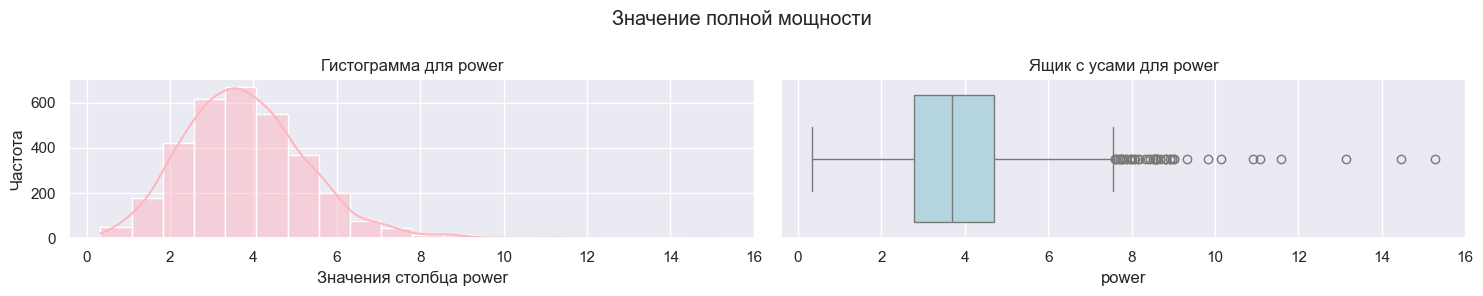

In [208]:
# визуализация признака 'power'
numeric(key_arc_new, 'power', 'Значение полной мощности')

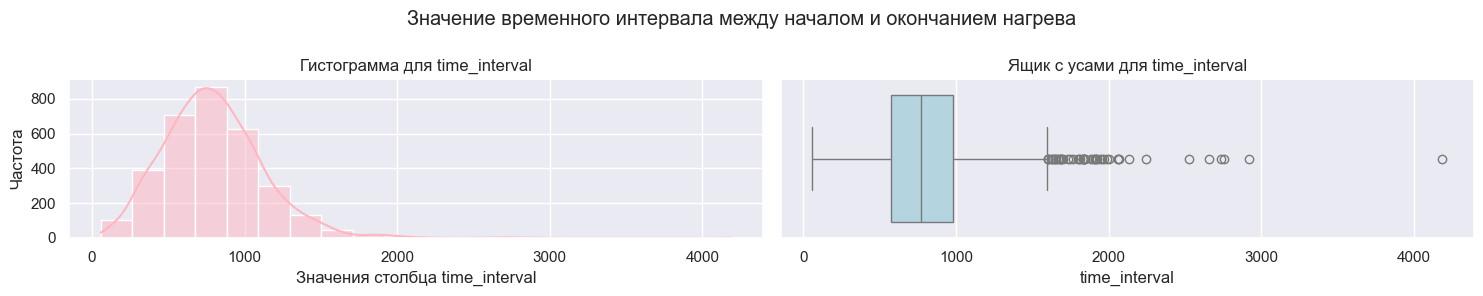

In [209]:
# визуализация признака 'time_interval'
numeric(key_arc_new, 'time_interval', 'Значение временного интервала между началом и окончанием нагрева')

**Примечание:** Распределение обоих признаков похоже на нормальное или близко к нему. Выбросы есть для обоих признаков, но они не критичны для исследования (все критичные выбросы были обработаны ранее).

### Исследовательский анализ и предобработка данных таблицы 'data_bulk_new'

In [210]:
# снова посмотрим первые 5 строк таблицы
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [211]:
# посмотрим последние 5 строк таблицы
data_bulk_new.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [212]:
# для начала изменим названия столбцов, приведя их к общепринятому стилю
data_bulk_new = data_bulk_new.rename(columns={
    'Bulk 1' : 'bulk_1',
    'Bulk 2' : 'bulk_2',
    'Bulk 3' : 'bulk_3',
    'Bulk 4' : 'bulk_4',
    'Bulk 5' : 'bulk_5',
    'Bulk 6' : 'bulk_6',
    'Bulk 7' : 'bulk_7',
    'Bulk 8' : 'bulk_8',
    'Bulk 9' : 'bulk_9',
    'Bulk 10' : 'bulk_10',
    'Bulk 11' : 'bulk_11',
    'Bulk 12' : 'bulk_12',
    'Bulk 13' : 'bulk_13',
    'Bulk 14' : 'bulk_14',
    'Bulk 15' : 'bulk_15'
})

In [213]:
# посмотрим названия столбцов после изменения
data_bulk_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [214]:
# посмотрим информацию о таблице
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


**Примечание:** Названия столбцов приведены к общепринятому стилю, типы данных казаны корректно.

In [215]:
# посмотрим количество пропусков в данных
data_bulk_new.isna().sum()

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

**Примечание:** Видно, что присутствует достаточно много пропущенных значений, однако, это те пропуски, когда во время производства материал не подавался, соответственно, это естественный процесс производства, а значит, что все присутствующие пропуски можно заметить на ноль.

In [216]:
# заполним пропущенные значения
data_bulk_new = data_bulk_new.fillna(0)

# посмотрим количество пропусков после заполнения
data_bulk_new.isna().sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

In [217]:
# проверим датафрейм на наличие явных дубликатов
data_bulk_new.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутсвуют.

In [218]:
# проведем статистический анализ количественных признаков
print('Описательная статистика для количественных признаков:')
data_bulk_new.describe(include=[np.number])

Описательная статистика для количественных признаков:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


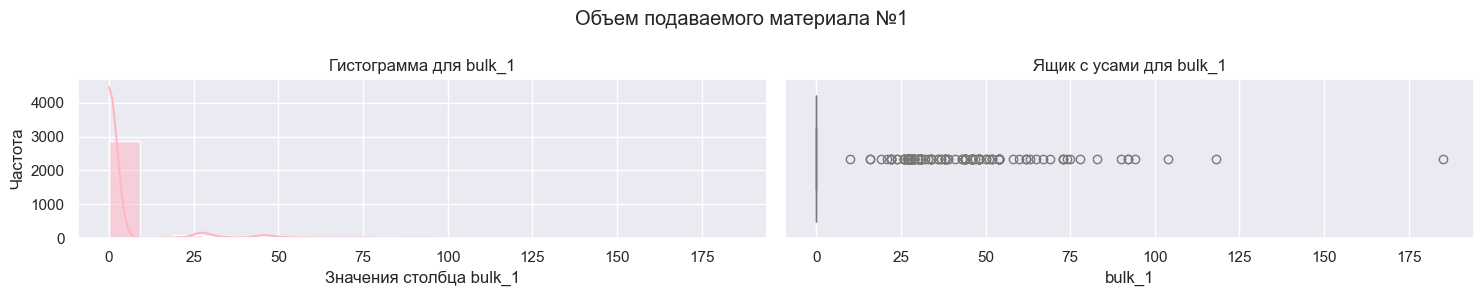

In [219]:
# визуализация признака 'bulk_1'
numeric(data_bulk_new, 'bulk_1', 'Объем подаваемого материала №1')

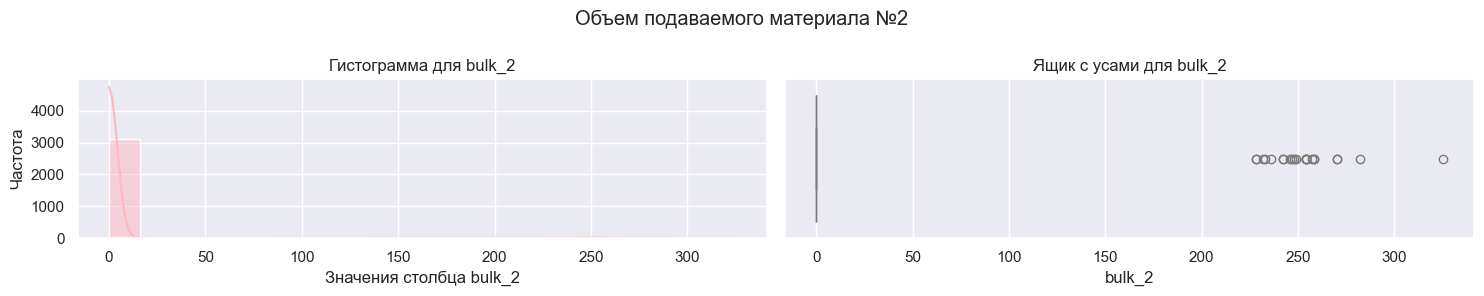

In [220]:
# визуализация признака 'bulk_2'
numeric(data_bulk_new, 'bulk_2', 'Объем подаваемого материала №2')

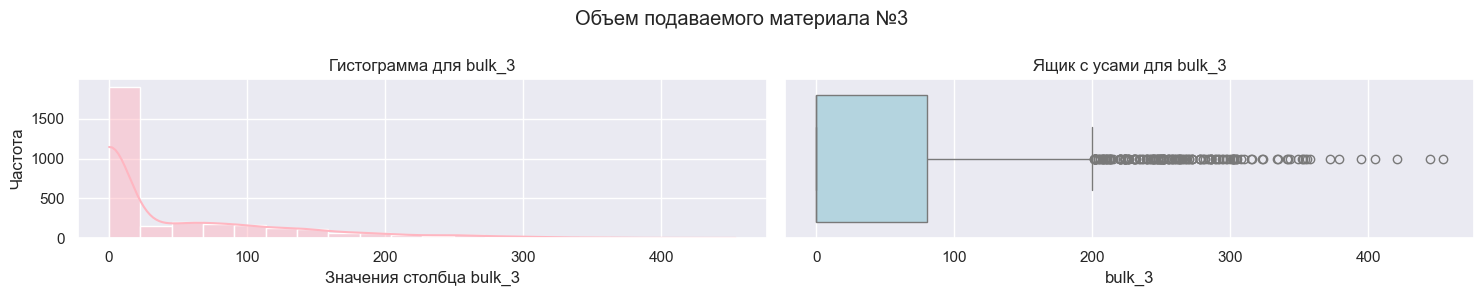

In [221]:
# визуализация признака 'bulk_3'
numeric(data_bulk_new, 'bulk_3', 'Объем подаваемого материала №3')

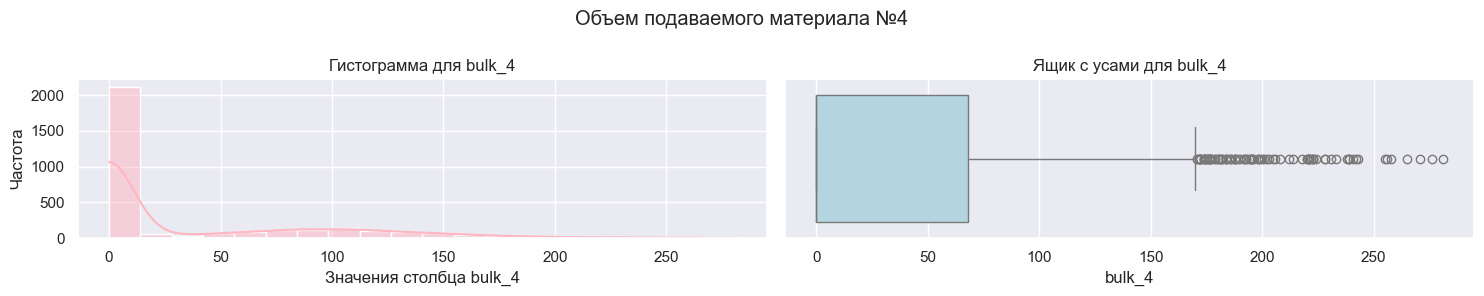

In [222]:
# визуализация признака 'bulk_4'
numeric(data_bulk_new, 'bulk_4', 'Объем подаваемого материала №4')

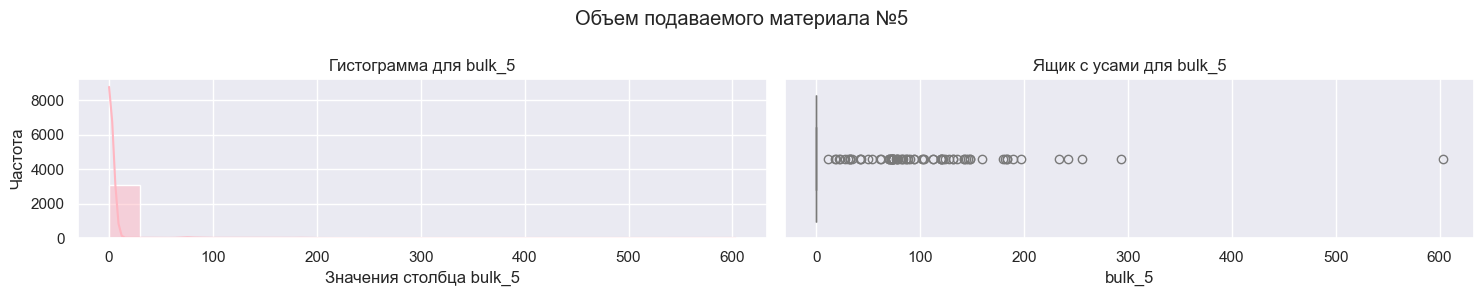

In [223]:
# визуализация признака 'bulk_5'
numeric(data_bulk_new, 'bulk_5', 'Объем подаваемого материала №5')

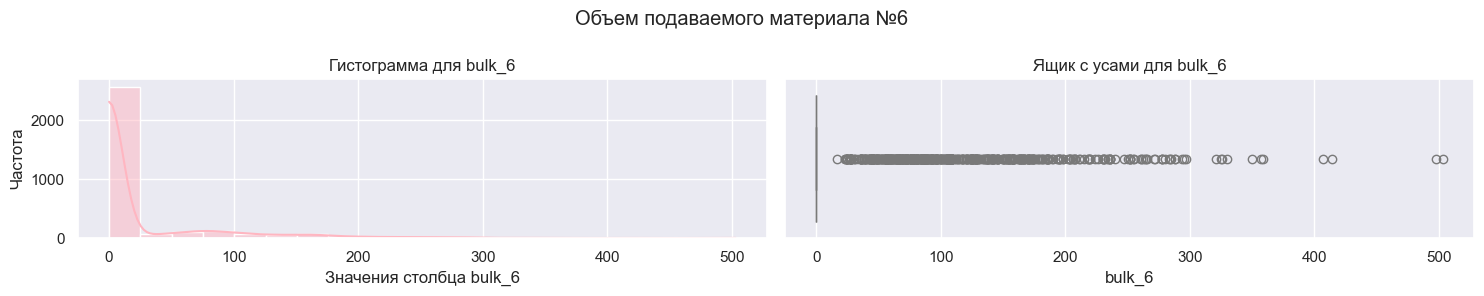

In [224]:
# визуализация признака 'bulk_6'
numeric(data_bulk_new, 'bulk_6', 'Объем подаваемого материала №6')

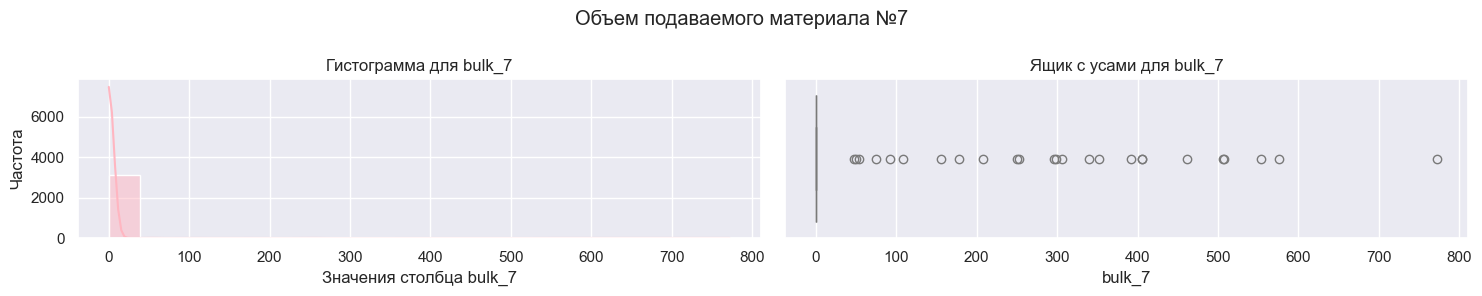

In [225]:
# визуализация признака 'bulk_7'
numeric(data_bulk_new, 'bulk_7', 'Объем подаваемого материала №7')

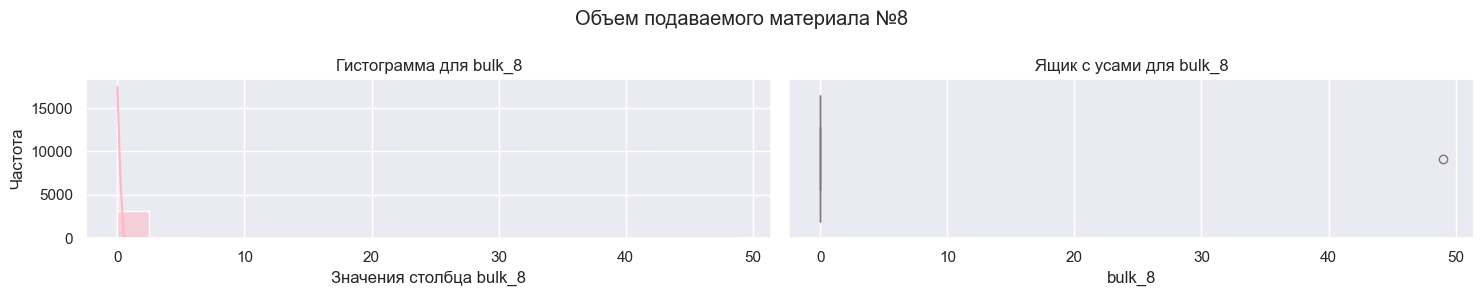

In [226]:
# визуализация признака 'bulk_8'
numeric(data_bulk_new, 'bulk_8', 'Объем подаваемого материала №8')

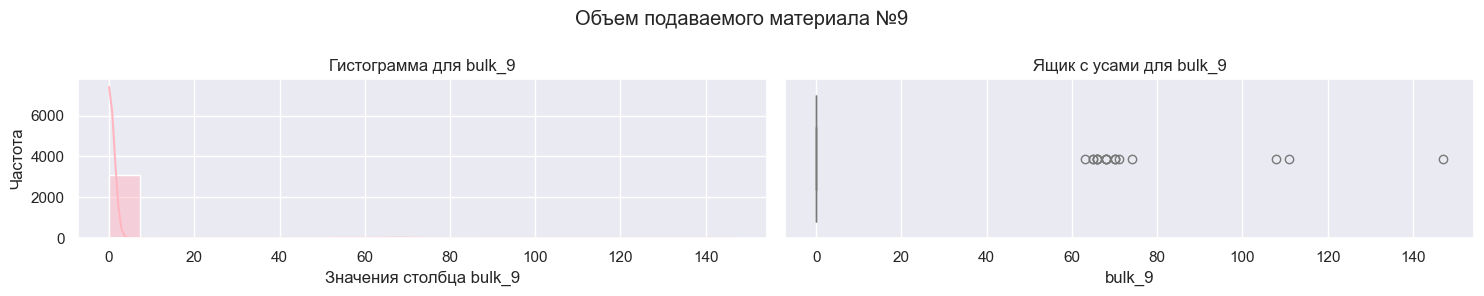

In [227]:
# визуализация признака 'bulk_9'
numeric(data_bulk_new, 'bulk_9', 'Объем подаваемого материала №9')

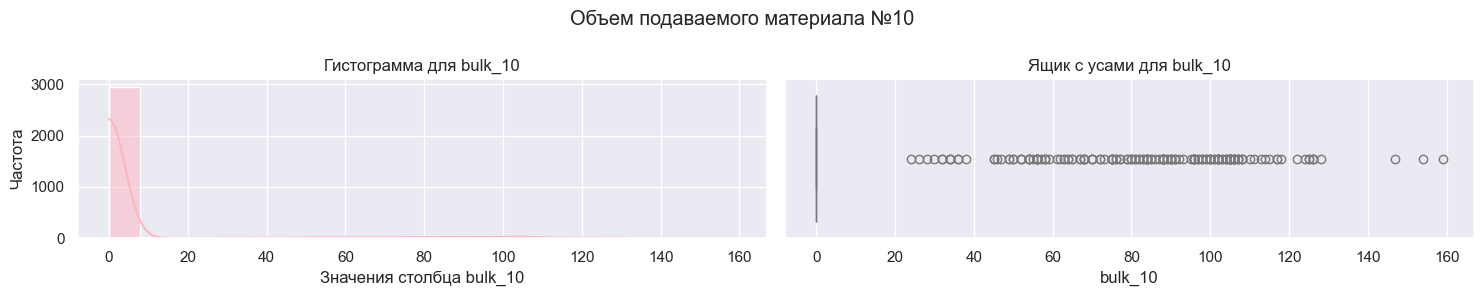

In [228]:
# визуализация признака 'bulk_10'
numeric(data_bulk_new, 'bulk_10', 'Объем подаваемого материала №10')

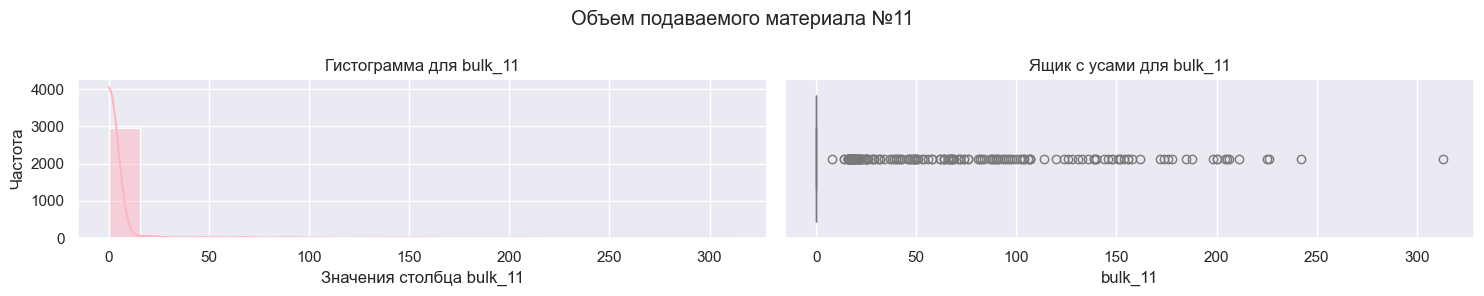

In [229]:
# визуализация признака 'bulk_11'
numeric(data_bulk_new, 'bulk_11', 'Объем подаваемого материала №11')

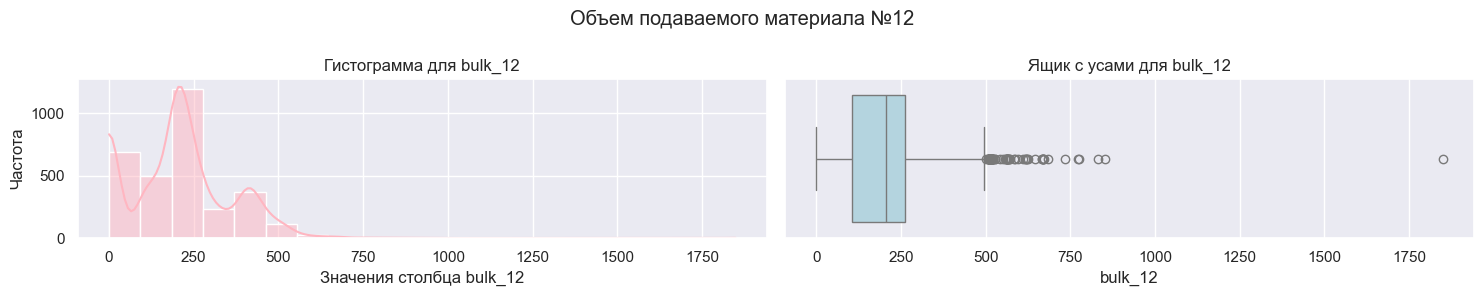

In [230]:
# визуализация признака 'bulk_12'
numeric(data_bulk_new, 'bulk_12', 'Объем подаваемого материала №12')

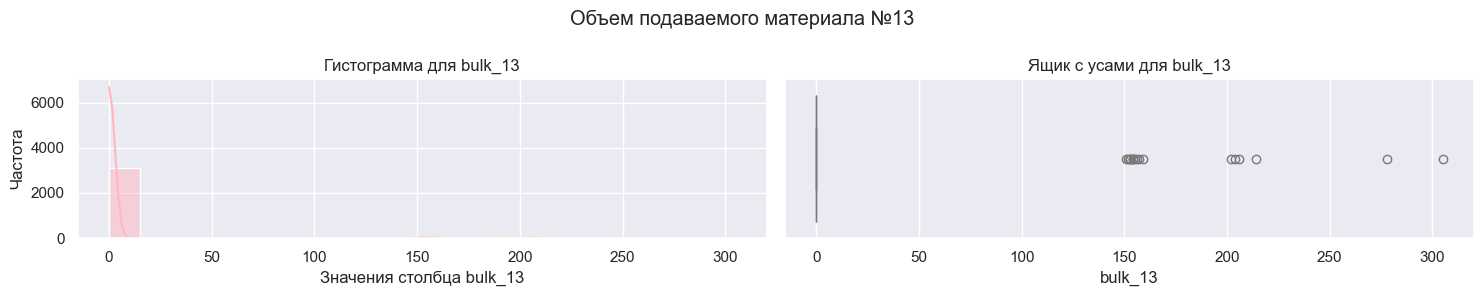

In [231]:
# визуализация признака 'bulk_13'
numeric(data_bulk_new, 'bulk_13', 'Объем подаваемого материала №13')

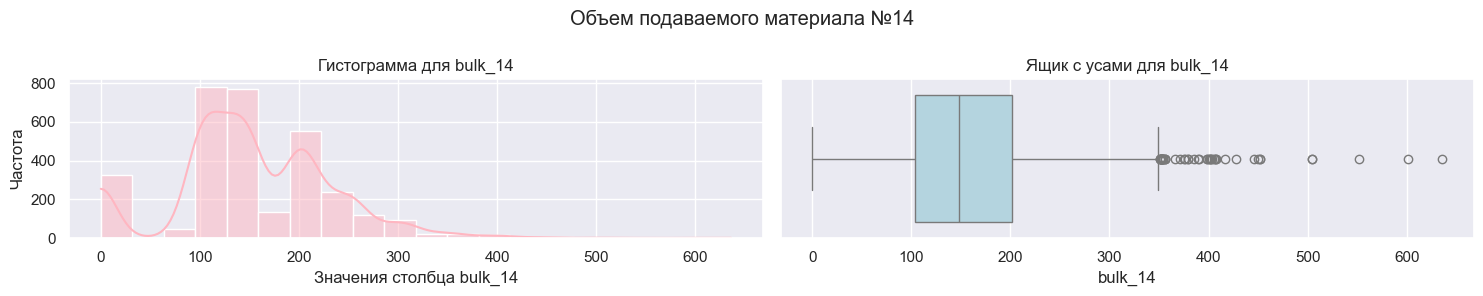

In [232]:
# визуализация признака 'bulk_14'
numeric(data_bulk_new, 'bulk_14', 'Объем подаваемого материала №14')

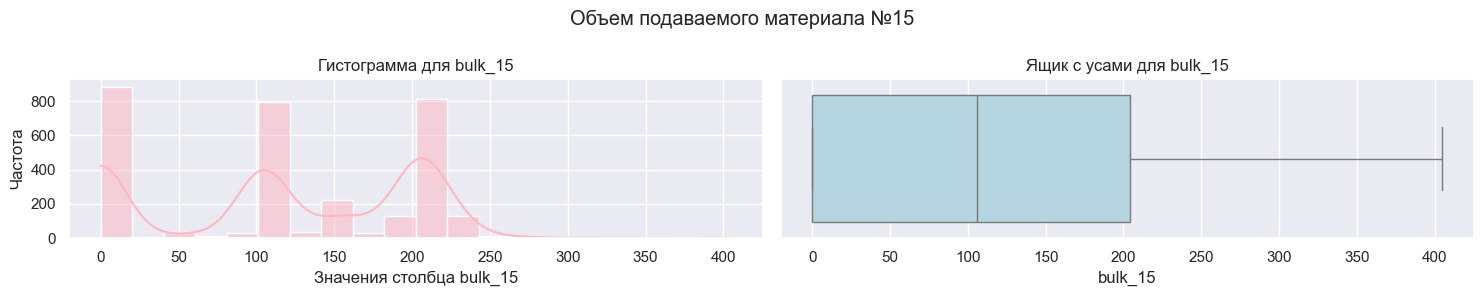

In [233]:
# визуализация признака 'bulk_15'
numeric(data_bulk_new, 'bulk_15', 'Объем подаваемого материала №15')

**Примечание:** Почти для каждого из разов, когда подавался тот или иной объем производства, присутствуют выбросы, однако эти выбросы связаны с процессом производства, поэтому они останутся без изменений.

In [234]:
# стоит отметить, что в данной таблице партии производства идут по порядку и каждая из них встречается один раз
# поэтому для каждой итерации можно посчитать сумму тех, где ничего не добавляется для уменьшения общего количества признаков
data_bulk_new['all_bulk_zero'] = data_bulk_new[['bulk_1', 'bulk_2', 'bulk_5', 
                                          'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                                          'bulk_11', 'bulk_13']].sum(axis=1)

# посмотрим первые 5 строк новой таблицы
data_bulk_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,all_bulk_zero
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0.0


### Исследовательский анализ и предобработка данных таблицы 'data_gas_new'

In [235]:
# снова посмотрим первые 5 строк таблицы
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [236]:
# для начала изменим названия столбцов, приведя их к общепринятому стилю
data_gas_new = data_gas_new.rename(columns={
    'Газ 1' : 'gas_1'
})

In [237]:
# посмотрим названия столбцов после изменения
data_gas_new.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [238]:
# посмотрим информацию о таблице
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [239]:
# посмотрим количество пропусков в данных
data_gas_new.isna().sum()

key      0
gas_1    0
dtype: int64

**Примечание:** Пропуски в данных отсутствуют.

In [240]:
# проверим датафрейм на наличие явных дубликатов
data_gas_new.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутствуют.

In [241]:
# проведем статистический анализ количественных признаков
print('Описательная статистика для количественных признаков:')
data_gas_new.describe(include=[np.number])

Описательная статистика для количественных признаков:


,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


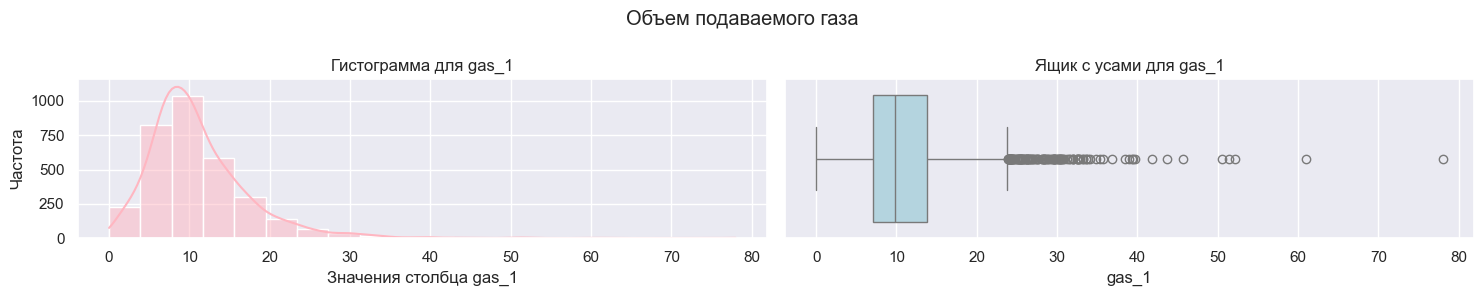

In [242]:
# визуализация признака 'gas_1'
numeric(data_gas_new, 'gas_1', 'Объем подаваемого газа')

**Примечание:** По результатм визуализации стало видно, что присутствует достаточно много выбросов, однако они удалены не будут, т.к. являются нормальными при процессе производства.

### Исследовательский анализ и предобработка данных таблицы 'data_temp_new'

In [243]:
# снова посмотрим первые 5 строк таблицы
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [244]:
# для начала изменим названия столбцов, приведя их к общепринятому стилю
data_temp_new = data_temp_new.rename(columns={
    'Время замера' : 'measurement_time',
    'Температура' : 'temperature'
})

In [245]:
# посмотрим названия столбцов после изменения
data_temp_new.head()

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [246]:
# посмотрим информацию о таблице
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               18092 non-null  int64  
 1   measurement_time  18092 non-null  object 
 2   temperature       14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [247]:
# столбец 'measurement_time' имеет неправильный тип данных, необходимо заменить на 'datetime'
data_temp_new['measurement_time'] = pd.to_datetime(data_temp_new['measurement_time'])

In [248]:
# посмотрим общую информацию о таблице после изменений
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18092 non-null  int64         
 1   measurement_time  18092 non-null  datetime64[ns]
 2   temperature       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [249]:
# посмотрим количество пропусков в данных
data_temp_new.isna().sum()

key                    0
measurement_time       0
temperature         3427
dtype: int64

**Примечание:** Присутствует достаточно большое количество пропусков в столбце 'temperature', их необходимо обработать.

In [250]:
# проверим датафрейм на наличие явных дубликатов
data_temp_new.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты отсутствуют.

Также по условиям реализации задачи для заказчика конечная температура будет являться целевым признаком, который стоит предсказать, соответственно, в процессе работы стоит использовать начальную температуру, чтобы не произошла утечка данных. 

In [251]:
# разделим температуру на начальную и конечную, используя 'measurement_time'
# найдем все значения начальной температуры
data_temp_begin = data_temp_new.loc[data_temp_new.groupby(['key'])['measurement_time'].idxmin()]
# найдем все значения конечной температуры
data_temp_end = data_temp_new.loc[data_temp_new.groupby(['key'])['measurement_time'].idxmax()]

In [252]:
# объединим две разделенные таблицы в одну по столбцу 'key'
data_temp = pd.merge(data_temp_begin, data_temp_end, on='key')

# посмотрим первые 5 строк получившейся таблицы
data_temp.head()

,key,measurement_time_x,temperature_x,measurement_time_y,temperature_y
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


**Примечание:** Таблицы объединились корректно, однако, названия столбцов не очень ясны, поэтому их стоит переименовать.

In [253]:
# переименуем столбцы в получившейся таблице
data_temp = data_temp.rename(columns={
    'measurement_time_x' : 'measurement_time_begin',
    'temperature_x' : 'temperature_begin',
    'measurement_time_y' : 'measurement_time_end',
    'temperature_y' : 'temperature_end'
})

In [254]:
# посмотрим таблицу после переименования столбцов
data_temp.head()

,key,measurement_time_begin,temperature_begin,measurement_time_end,temperature_end
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


In [255]:
# посмотрим общую информацию о таблице
data_temp.describe()

,key,measurement_time_begin,temperature_begin,measurement_time_end,temperature_end
count,3216.000000,3216,3216.000000,3216,2477.000000
mean,1622.199316,2019-07-05 18:29:12.356654336,1588.592040,2019-07-05 19:06:41.977611776,1595.334275
min,1.000000,2019-05-03 11:02:04,1191.000000,2019-05-03 11:30:38,1541.000000
25%,815.750000,2019-06-04 08:25:05.750000128,1572.000000,2019-06-04 09:18:21,1587.000000
50%,1622.500000,2019-07-03 05:00:56.500000,1588.000000,2019-07-03 05:39:20,1593.000000
75%,2431.250000,2019-08-08 00:02:23,1606.000000,2019-08-08 00:35:36.750000128,1599.000000
max,3241.000000,2019-09-06 16:48:55,1684.000000,2019-09-06 17:30:05,1700.000000
std,935.088523,NaN,29.137454,NaN,16.019339


**Примечание:** По полученным результатам видно, что в столбце 'temperature_begin' присутствует аномалия, т.к. минимальная температура в ней равна 1191.00, но стоит отметить, что по результатам поиска, было найдено, что минимальная температура нагрева стали равна 1400.00. Эту аномалию стоит обработать.

In [256]:
# посмотрим сколько в таблице записей с начальной температурой меньше, чем 1400.00
data_temp[data_temp['temperature_begin'] < 1400]

,key,measurement_time_begin,temperature_begin,measurement_time_end,temperature_end
855,867,2019-06-06 08:03:39,1191.0,2019-06-06 08:48:23,1599.0
1201,1214,2019-06-18 08:01:03,1208.0,2019-06-18 08:43:56,1591.0
1604,1619,2019-07-03 02:34:41,1218.0,2019-07-03 02:43:59,1590.0
2036,2052,2019-07-25 08:49:15,1227.0,2019-07-25 09:27:03,1592.0
2538,2561,2019-08-12 18:49:29,1204.0,2019-08-12 19:21:45,NaN


In [257]:
# записей с аномальной начальной температурой оказалось всего 5, их стоит удалить
data_temp = data_temp[data_temp['key'] != 867]
data_temp = data_temp[data_temp['key'] != 1214]
data_temp = data_temp[data_temp['key'] != 1619]
data_temp = data_temp[data_temp['key'] != 2052]
data_temp = data_temp[data_temp['key'] != 2561]

In [258]:
# посмотрим на кол-во строк с начальной температурой меньше 1400.00 после удаления
data_temp[data_temp['temperature_begin'] < 1400]

,key,measurement_time_begin,temperature_begin,measurement_time_end,temperature_end


**Примечание:** Аномально маленькие значения начальной температуры успешно обработаны.

In [259]:
# посмотрим количество пропусков в данных на нынешний момент
data_temp.isna().sum()

key                         0
measurement_time_begin      0
temperature_begin           0
measurement_time_end        0
temperature_end           738
dtype: int64

**Примечание:** В таблице присутствуют пропуски только в одном столбце, а именно 'temperature_end', который является целевым, соответственно востанавливать пропуски в этом столбце нецелесообразно, т.к. это действие может исказить предсказание. В связи с этим пропуски в этом столбце будут просто удалены.

In [260]:
# удалим пропуски в столбце 'temperature_end'
data_temp = data_temp.dropna()

# посмотрим кол-во пропусков в таблице после удаления
data_temp.isna().sum()

key                       0
measurement_time_begin    0
temperature_begin         0
measurement_time_end      0
temperature_end           0
dtype: int64

**Примечание:** Все аномалии и пропуски в данных успешно обработаны.

In [261]:
# проведем статистический анализ количественных признаков
print('Описательная статистика для количественных признаков:')
data_temp.describe(include=[np.number])

Описательная статистика для количественных признаков:


,key,temperature_begin,temperature_end
count,2473.000000,2473.000000,2473.000000
mean,1249.664375,1589.016175,1595.338051
std,720.395663,24.996127,16.031388
min,1.000000,1519.000000,1541.000000
25%,627.000000,1572.000000,1587.000000
50%,1251.000000,1588.000000,1593.000000
75%,1872.000000,1605.000000,1599.000000
max,2499.000000,1679.000000,1700.000000


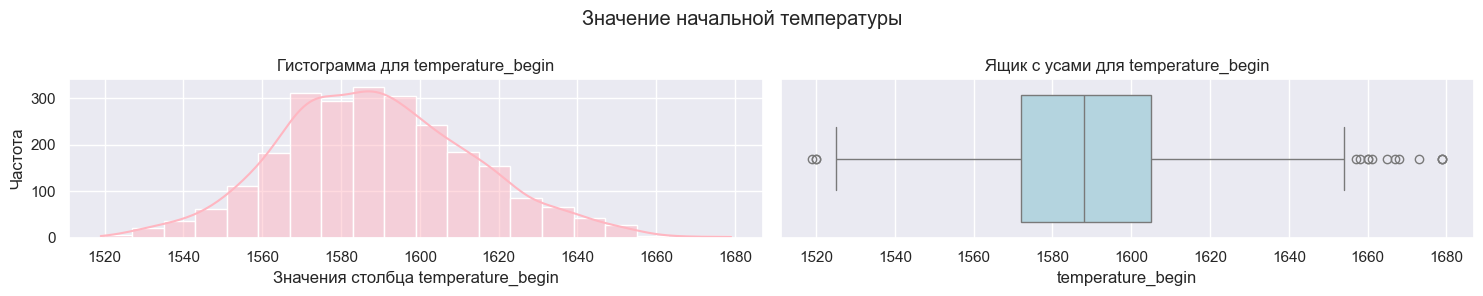

In [262]:
# визуализация признака 'temperature_begin'
numeric(data_temp, 'temperature_begin', 'Значение начальной температуры')

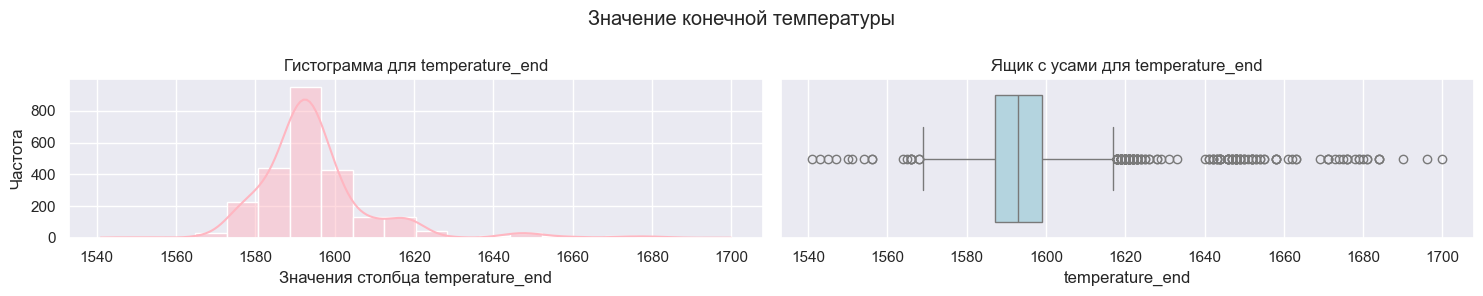

In [263]:
# визуализация признака 'temperature_end'
numeric(data_temp, 'temperature_end', 'Значение конечной температуры')

**Примечание:** По графикам тоже видно, что все критичные значения обработаны, жа, присутствуют и другие выбросы, но они не влияют на процесс исследования.

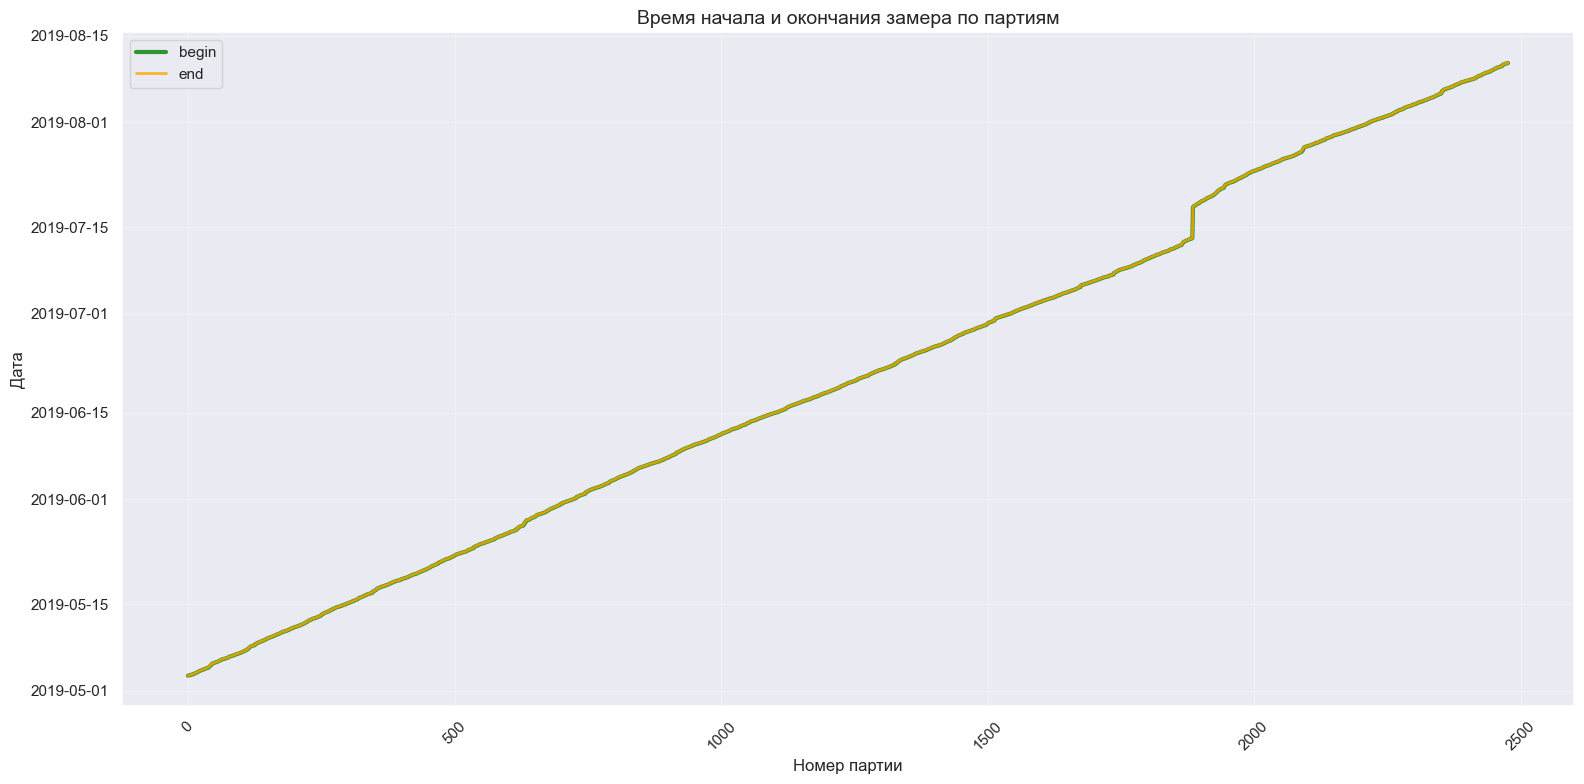

In [264]:
# визуализируем признаки начала и окончания времени замера
plt.figure(figsize=(16, 8))  

ax = data_temp['measurement_time_begin'].plot(label='begin', linewidth=3.0, color='green', alpha=0.8)
ax = data_temp['measurement_time_end'].plot(label='end', linewidth=2.0, color='orange', alpha=0.8)

ax.set_xlabel('Номер партии', fontsize=12)
ax.set_ylabel('Дата', fontsize=12)
ax.set_title('Время начала и окончания замера по партиям', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

**Примечание:** Время начала и окончания замера температуры не сильно важно для исследования (тем более, что ранее сама температура была разделена на начальную и конечную), но общее затраченное время может понадобиться для итогового предсказания температуры, поэтому рассчитаем его на всякий случай. Если посмотреть на значения таблицы, то в целом время замера температуры варьируется в пределах минуты, но некоторое и за считанные секунды, поэтому стоит рассчитать время в секундах, чтобы учесть всю продолжительность.

In [265]:
# рассчитаем интервал между началом и окончанием замера температуры в секундах
data_temp['time'] = data_temp['measurement_time_end'] - data_temp['measurement_time_begin']
data_temp['time'] = data_temp['time'].dt.total_seconds()

In [266]:
# посмотрим первые 5 строк таблицы с новым признаком
data_temp.head()

,key,measurement_time_begin,temperature_begin,measurement_time_end,temperature_end,time
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0


**Примечание:** После преобразования для нашего исследования можно оставить только признаки 'temperature_begin' (начальная температура), 'temperature_end' (конечная температура) и 'time' (промежуток времени между началом и окончанием замера температуры), остальные признаки не нужны, т.к. они включены в предыдущие два.

### Исследовательский анализ и предобработка данных таблицы 'data_wire_new'

In [267]:
# снова посмотрим первые 5 строк таблицы
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [268]:
# снова посмотрим первые 5 строк таблицы
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
# для начала изменим названия столбцов, приведя их к общепринятому стилю
data_wire_new = data_wire_new.rename(columns={
    'Wire 1' : 'wire_1',
    'Wire 2' : 'wire_2',
    'Wire 3' : 'wire_3',
    'Wire 4' : 'wire_4',
    'Wire 5' : 'wire_5',
    'Wire 6' : 'wire_6',
    'Wire 7' : 'wire_7',
    'Wire 8' : 'wire_8',
    'Wire 9' : 'wire_9'
})

In [270]:
# посмотрим названия столбцов после изменения
data_wire_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [271]:
# посмотрим информацию о таблице
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**Примечание:** Названия столбцов приведены к общепринятому стилю, типы данных указаны корректно.

In [272]:
# посмотрим количество пропусков в данных
data_wire_new.isna().sum()

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

**Примечание:** Видно, что присутствует достаточно много пропущенных значений, однако, это те пропуски, когда во время производства проволочный материал не подавался, соответственно, это естественный процесс производства, а значит, что все присутствующие пропуски можно заметить на ноль.

In [273]:
# заполним пропущенные значения
data_wire_new = data_wire_new.fillna(0)

# посмотрим количество пропусков после заполнения
data_wire_new.isna().sum()

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

In [274]:
# проверим датафрейм на наличие явных дубликатов
data_wire_new.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутсвуют.

In [275]:
# проведем статистический анализ количественных признаков
print('Описательная статистика для количественных признаков:')
data_wire_new.describe(include=[np.number])

Описательная статистика для количественных признаков:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


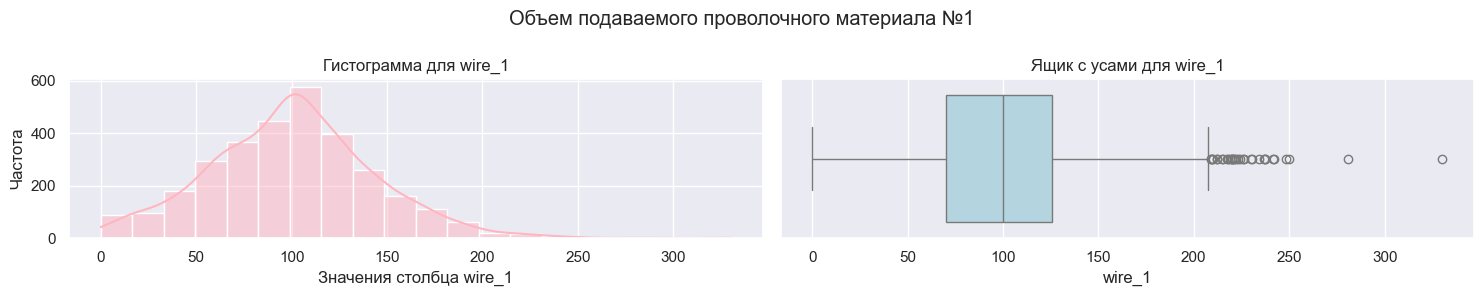

In [276]:
# визуализация признака 'wire_1'
numeric(data_wire_new, 'wire_1', 'Объем подаваемого проволочного материала №1')

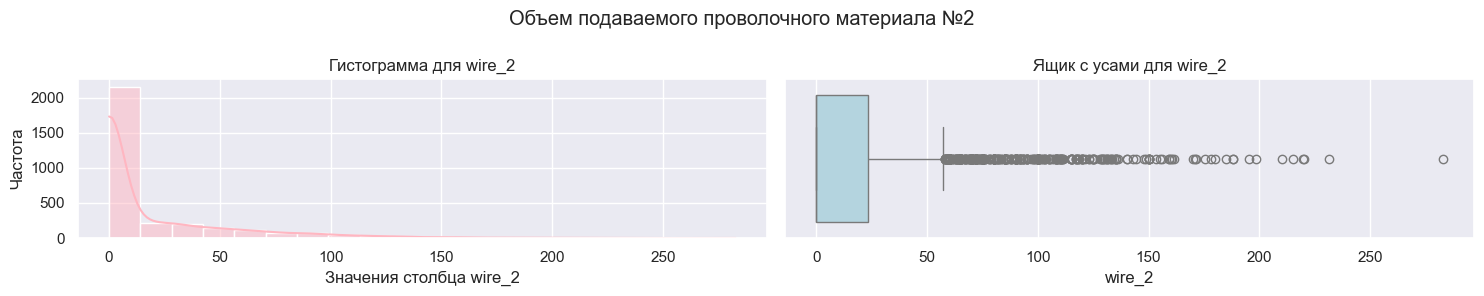

In [277]:
# визуализация признака 'wire_2'
numeric(data_wire_new, 'wire_2', 'Объем подаваемого проволочного материала №2')

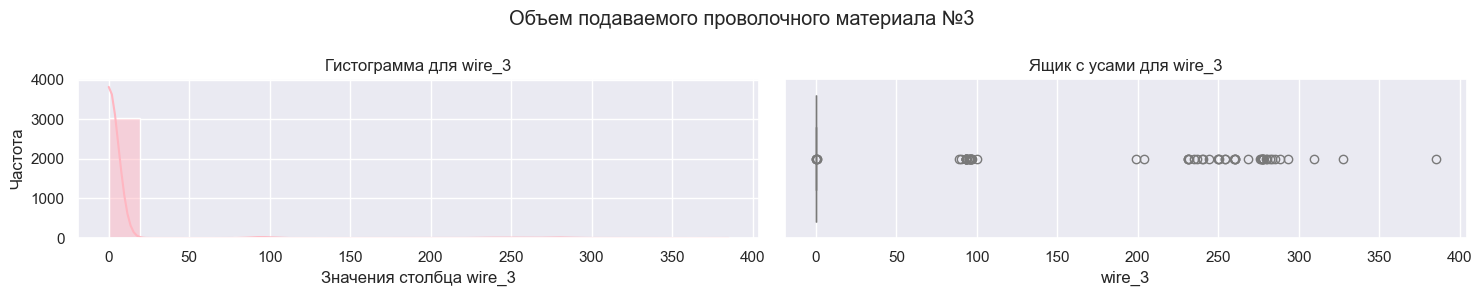

In [278]:
# визуализация признака 'wire_3'
numeric(data_wire_new, 'wire_3', 'Объем подаваемого проволочного материала №3')

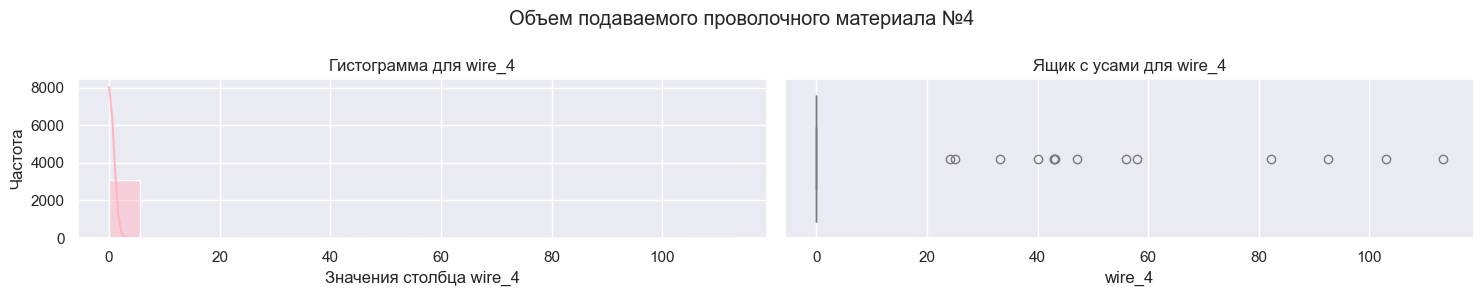

In [279]:
# визуализация признака 'wire_4'
numeric(data_wire_new, 'wire_4', 'Объем подаваемого проволочного материала №4')

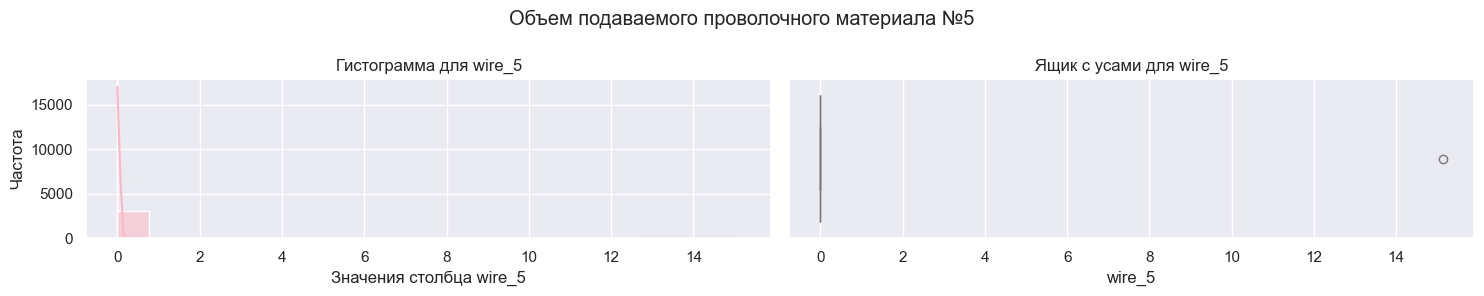

In [280]:
# визуализация признака 'wire_5'
numeric(data_wire_new, 'wire_5', 'Объем подаваемого проволочного материала №5')

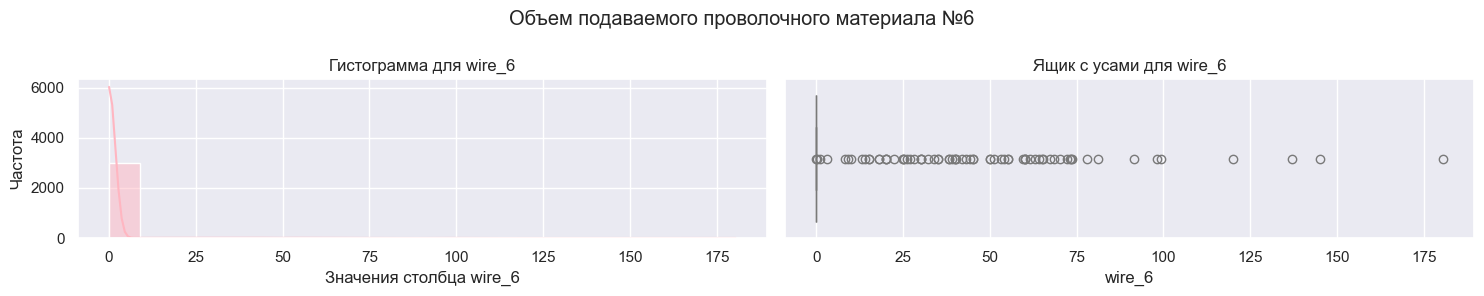

In [281]:
# визуализация признака 'wire_6'
numeric(data_wire_new, 'wire_6', 'Объем подаваемого проволочного материала №6')

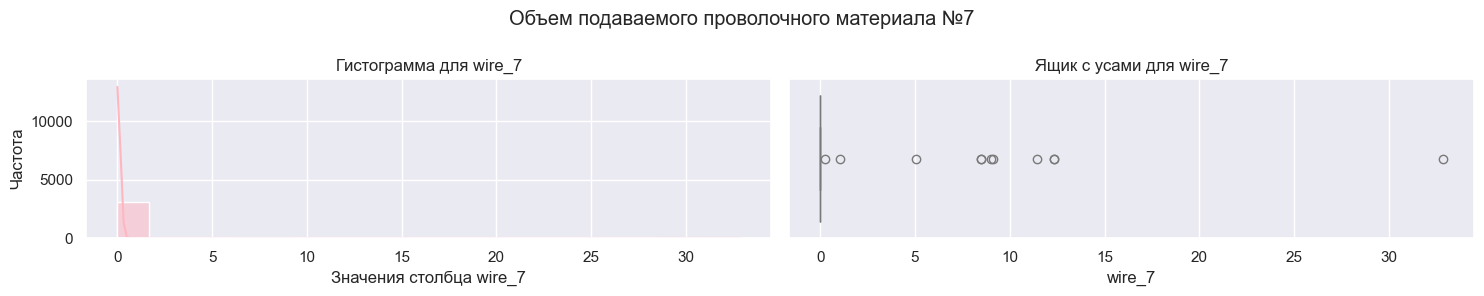

In [282]:
# визуализация признака 'wire_7'
numeric(data_wire_new, 'wire_7', 'Объем подаваемого проволочного материала №7')

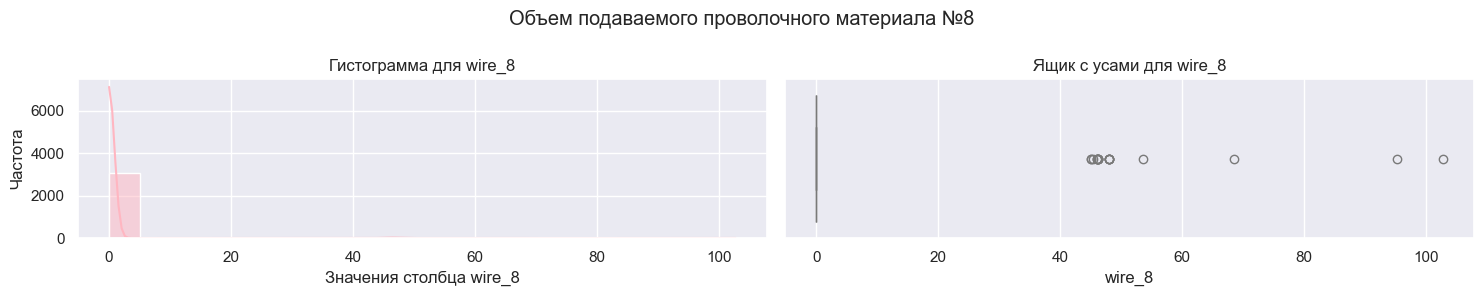

In [283]:
# визуализация признака 'wire_8'
numeric(data_wire_new, 'wire_8', 'Объем подаваемого проволочного материала №8')

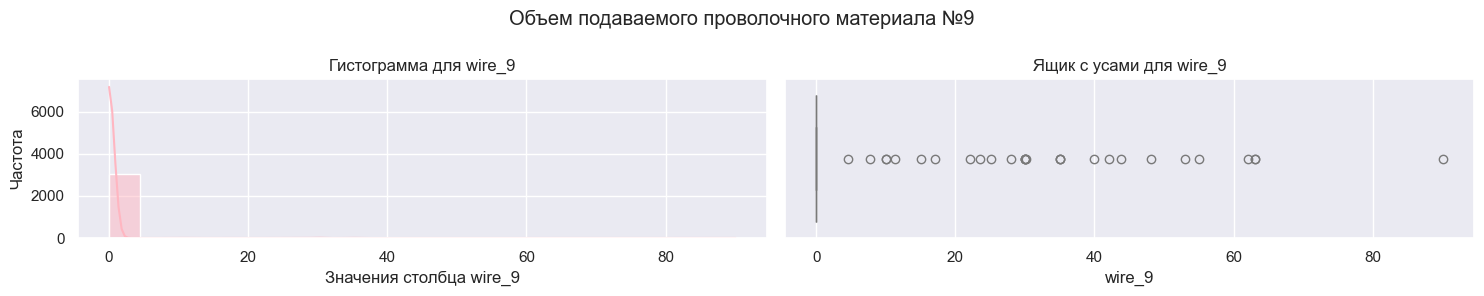

In [284]:
# визуализация признака 'wire_9'
numeric(data_wire_new, 'wire_9', 'Объем подаваемого проволочного материала №9')

**Примечание:** Почти для каждого из разов, когда подавался тот или иной объем производства, присутствуют выбросы, однако эти выбросы связаны с процессом производства, поэтому они останутся без изменений.

In [285]:
# стоит отметить, что в данной таблице партии производства идут по порядку и каждая из них встречается один раз
# поэтому для каждой итерации можно посчитать сумму тех, где ничего не добавляется для уменьшения общего количества признаков
data_wire_new['all_wire_zero'] = data_wire_new[['wire_3', 'wire_4', 'wire_5', 
                                          'wire_6', 'wire_7', 'wire_8', 'wire_9']].sum(axis=1)

# посмотрим первые 5 строк новой таблицы
data_wire_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,all_wire_zero
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Обобщающий вывод этапа "Исследовательский анализ и предобработка данных":**
1. Названия во всех таблицах приведены к общепринятому "змеиному" стилю.
2. Во всех таблицах отсутствуют явные дубликаты.
3. Пропуски в таблицах 'data_bulk_new' и 'data_wire_new' заполнены нулями.
4. В таблицах 'data_arc_new' и 'data_temp_new' обработаны аномалии в столбцах 'reactive_power' (реактивная мощность) и 'temperature_begin' (начальная температура) соответственно.
5. Рассчитаны новые признаки: 'power' (полная мощность, включающая в себя активную и реактивную мощности), 'time_interval' (время в секундах между началом и окончанием нагрева), 'all_bulk_zero' (столбец со значениями всех нулевых итераций по подаче материалов), 'temperature_begin' и 'temperature_end' (начальная и конечная температуры соответственно), 'time' (время в секундах между началом и окончанием нагрева температуры), 'all_wire_zero' (столбец со значениями всех нулевых итераций по подаче проволочных материалов).

## Объединение данных

In [286]:
# для будущего построения моделей объединим все получившиеся таблицы из п.2 и удалим оттуда неинформативные столбцы
data = pd.merge(key_arc_new, data_bulk_new, on='key')
data = data.merge(data_gas_new, on='key')
data = data.merge(data_temp, on='key')
data = data.merge(data_wire_new, on='key')

In [287]:
# посмотрим первые 5 строк получившейся таблицы
data.head()

,key,power,time_interval,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,all_wire_zero
0,1,3.718736,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2.588349,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5.019223,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3.400038,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2.816980,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [288]:
# т.к. не все столбцы нужны для исследования, посмотрим список и удалим ненужные
data.columns

Index(['key', 'power', 'time_interval', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
       'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
       'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'all_bulk_zero', 'gas_1',
       'measurement_time_begin', 'temperature_begin', 'measurement_time_end',
       'temperature_end', 'time', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'all_wire_zero'],
      dtype='object')

In [289]:
data = data.drop(['bulk_1', 'bulk_2',
                'bulk_5', 'bulk_7',
                'bulk_8', 'bulk_9',
                'bulk_10', 'bulk_11',
                'bulk_13', 'measurement_time_begin',
                'measurement_time_end', 'wire_3',
                'wire_4','wire_5', 
                'wire_6', 'wire_7', 
                'wire_8','wire_9'], axis=1)

In [290]:
# посмотрим получившуюся таблицу
data.head()

,key,power,time_interval,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,all_bulk_zero,gas_1,temperature_begin,temperature_end,time,wire_1,wire_2,all_wire_zero
0,1,3.718736,1098.0,0.0,43.0,0.0,206.0,150.0,154.0,0.0,29.749986,1571.0,1613.0,1714.0,60.059998,0.00000,0.0
1,2,2.588349,811.0,0.0,73.0,0.0,206.0,149.0,154.0,0.0,12.555561,1581.0,1602.0,1265.0,96.052315,0.00000,0.0
2,3,5.019223,655.0,0.0,34.0,0.0,205.0,152.0,153.0,0.0,28.554793,1596.0,1599.0,1753.0,91.160157,0.00000,0.0
3,4,3.400038,741.0,0.0,81.0,0.0,207.0,153.0,154.0,0.0,18.841219,1601.0,1625.0,1220.0,89.063515,0.00000,0.0
4,5,2.816980,869.0,0.0,78.0,0.0,203.0,151.0,152.0,0.0,5.413692,1576.0,1602.0,1536.0,89.238236,9.11456,0.0


In [291]:
# в целом признак 'key' тоже является неинформативным для исследования, поэтому удалим его
data = data.drop(['key'], axis=1)

In [292]:
# посмотрим общую информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   power              2324 non-null   float64
 1   time_interval      2324 non-null   float64
 2   bulk_3             2324 non-null   float64
 3   bulk_4             2324 non-null   float64
 4   bulk_6             2324 non-null   float64
 5   bulk_12            2324 non-null   float64
 6   bulk_14            2324 non-null   float64
 7   bulk_15            2324 non-null   float64
 8   all_bulk_zero      2324 non-null   float64
 9   gas_1              2324 non-null   float64
 10  temperature_begin  2324 non-null   float64
 11  temperature_end    2324 non-null   float64
 12  time               2324 non-null   float64
 13  wire_1             2324 non-null   float64
 14  wire_2             2324 non-null   float64
 15  all_wire_zero      2324 non-null   float64
dtypes: float64(16)
memory us

In [293]:
# посмотрим полученную таблицу на наличие пропусков
data.isna().sum()

power                0
time_interval        0
bulk_3               0
bulk_4               0
bulk_6               0
bulk_12              0
bulk_14              0
bulk_15              0
all_bulk_zero        0
gas_1                0
temperature_begin    0
temperature_end      0
time                 0
wire_1               0
wire_2               0
all_wire_zero        0
dtype: int64

In [294]:
# посмотрим полученную таблицу на наличие явных дубликатов
data.duplicated().sum()

np.int64(0)

**Обобщающий вывод этапа "Объединение таблиц":**
1. На данном этапе все 5 таблиц после предобработки были объединены в одну общую таблицу.
2. Также были удалены столбцы, которые не являются информативными для исследования, а именно вся необходимая инфрмация из них содержится в других столбцах.
3. Пропуски и явные дубликаты в полученной таблице отсутствуют.

## Исследовательский анализ и предобработка данных объединенного датафрейма

In [295]:
# снова посмотрим первые 5 строк получившегося датафрейма
data.head()

,power,time_interval,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,all_bulk_zero,gas_1,temperature_begin,temperature_end,time,wire_1,wire_2,all_wire_zero
0,3.718736,1098.0,0.0,43.0,0.0,206.0,150.0,154.0,0.0,29.749986,1571.0,1613.0,1714.0,60.059998,0.00000,0.0
1,2.588349,811.0,0.0,73.0,0.0,206.0,149.0,154.0,0.0,12.555561,1581.0,1602.0,1265.0,96.052315,0.00000,0.0
2,5.019223,655.0,0.0,34.0,0.0,205.0,152.0,153.0,0.0,28.554793,1596.0,1599.0,1753.0,91.160157,0.00000,0.0
3,3.400038,741.0,0.0,81.0,0.0,207.0,153.0,154.0,0.0,18.841219,1601.0,1625.0,1220.0,89.063515,0.00000,0.0
4,2.816980,869.0,0.0,78.0,0.0,203.0,151.0,152.0,0.0,5.413692,1576.0,1602.0,1536.0,89.238236,9.11456,0.0


In [296]:
# в нашем датафрейме присутствуют только количественные признаки, посмотрим их описательную статистику
print('Описательная статистика для количественных признаков:')
data.describe(include=[np.number])

Описательная статистика для количественных признаков:


,power,time_interval,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,all_bulk_zero,gas_1,temperature_begin,temperature_end,time,wire_1,wire_2,all_wire_zero
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,3.886143,808.196644,47.317126,37.347676,22.419535,208.597676,153.952668,120.078313,20.370052,11.378854,1587.368761,1593.372633,2323.682014,102.423900,17.613213,5.166161
std,1.517584,340.813828,75.238050,58.677890,55.792509,157.112117,81.410544,84.655967,69.082754,6.397008,23.627590,11.207457,1385.809791,43.540975,33.648176,32.883894
min,0.331897,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000,339.000000,0.000000,0.000000,0.000000
25%,2.846893,581.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,0.000000,7.282534,1571.000000,1587.000000,1580.500000,73.204559,0.000000,0.000000
50%,3.770584,778.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,0.000000,10.100687,1587.000000,1593.000000,2046.500000,101.103600,0.000000,0.000000
75%,4.769753,993.000000,80.000000,77.250000,0.000000,283.000000,204.000000,204.000000,0.000000,14.218487,1603.000000,1598.000000,2793.500000,128.075222,23.102560,0.000000
max,15.288271,4189.000000,454.000000,281.000000,503.000000,1849.000000,636.000000,405.000000,1187.000000,77.995040,1660.000000,1653.000000,23674.000000,330.314424,282.780152,385.008668


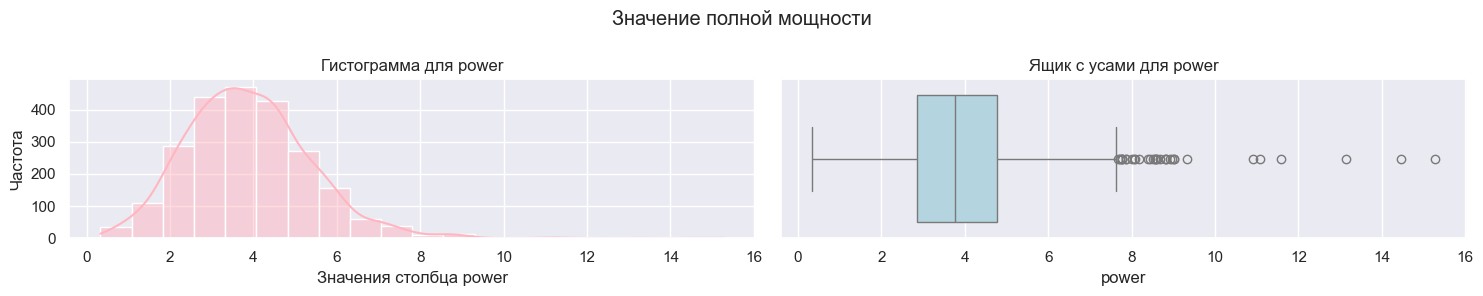

In [297]:
# визуализация признака 'power'
numeric(data, 'power', 'Значение полной мощности')

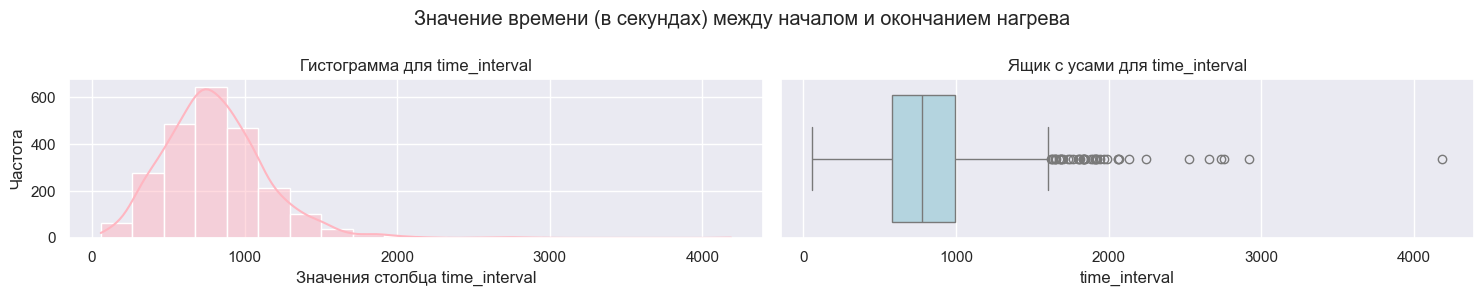

In [298]:
# визуализация признака 'time_interval'
numeric(data, 'time_interval', 'Значение времени (в секундах) между началом и окончанием нагрева')

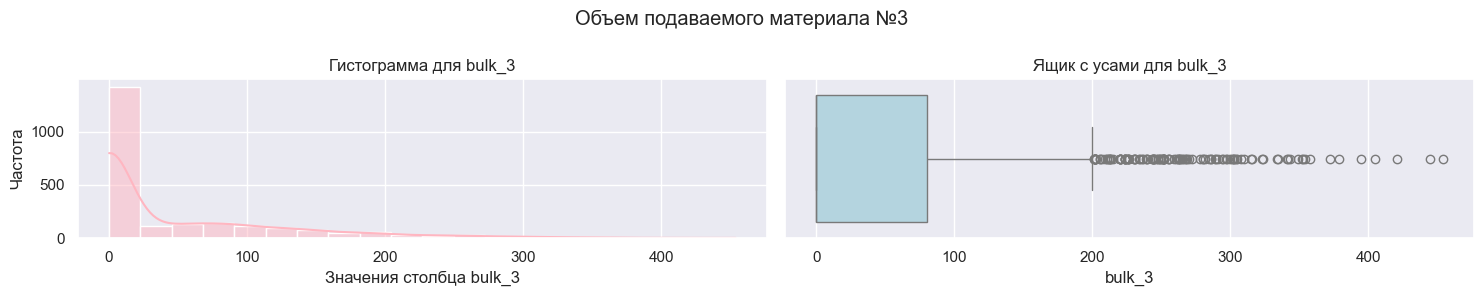

In [299]:
# визуализация признака 'bulk_3'
numeric(data, 'bulk_3', 'Объем подаваемого материала №3')

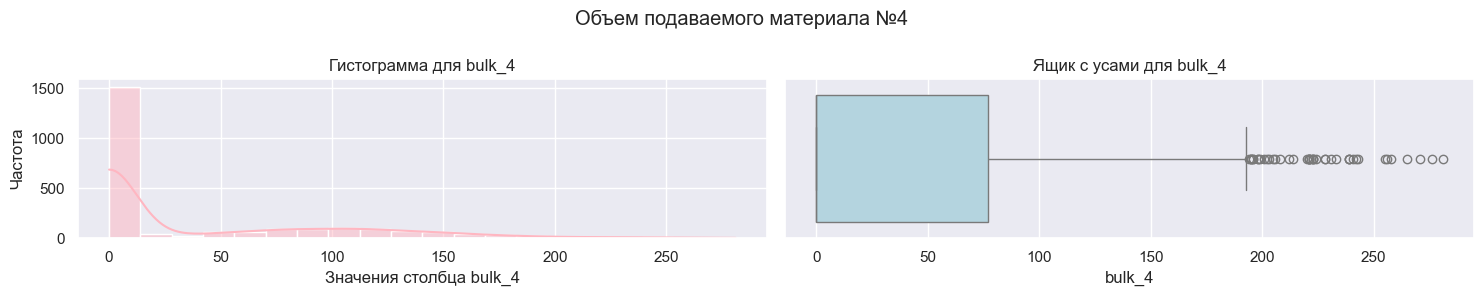

In [300]:
# визуализация признака 'bulk_4'
numeric(data, 'bulk_4', 'Объем подаваемого материала №4')

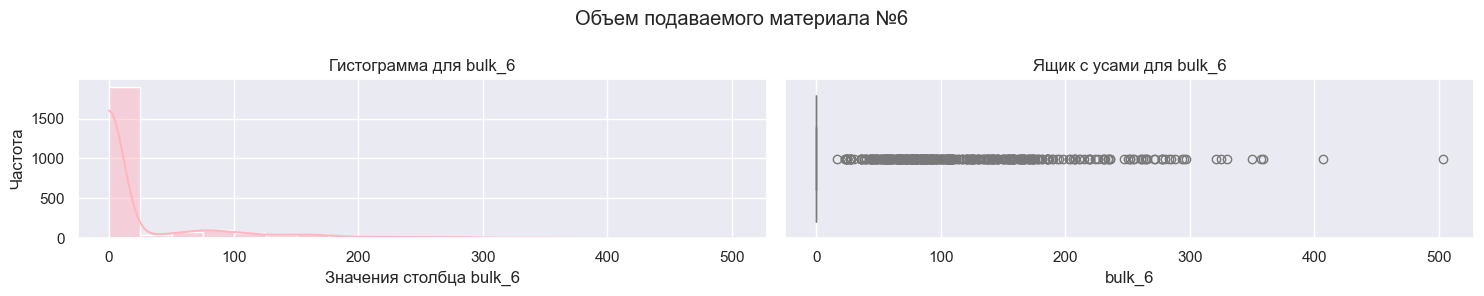

In [301]:
# визуализация признака 'bulk_6'
numeric(data, 'bulk_6', 'Объем подаваемого материала №6')

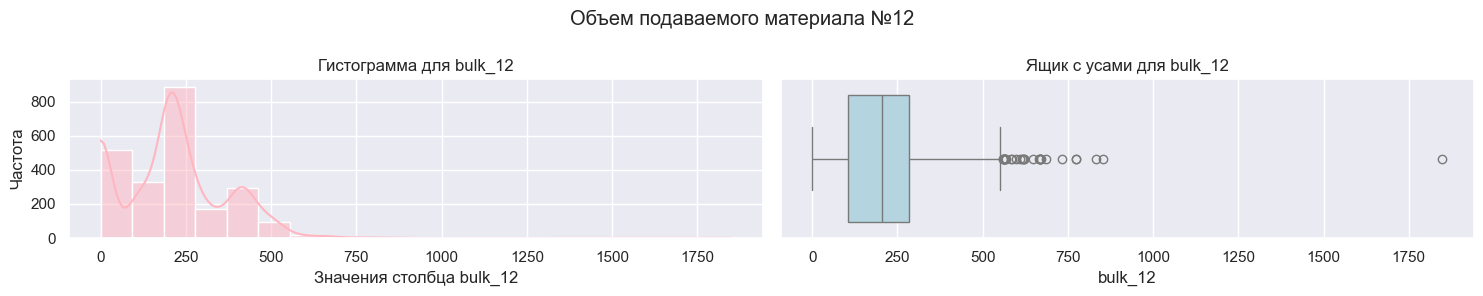

In [302]:
# визуализация признака 'bulk_12'
numeric(data, 'bulk_12', 'Объем подаваемого материала №12')

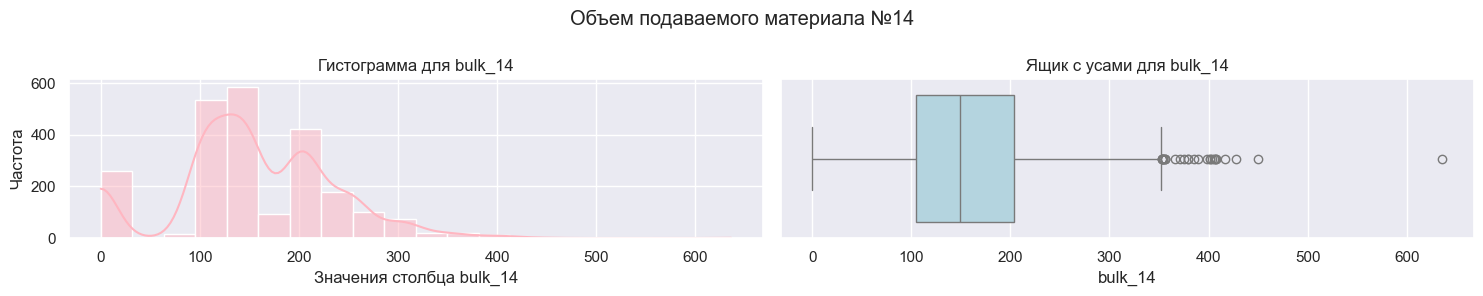

In [303]:
# визуализация признака 'bulk_14'
numeric(data, 'bulk_14', 'Объем подаваемого материала №14')

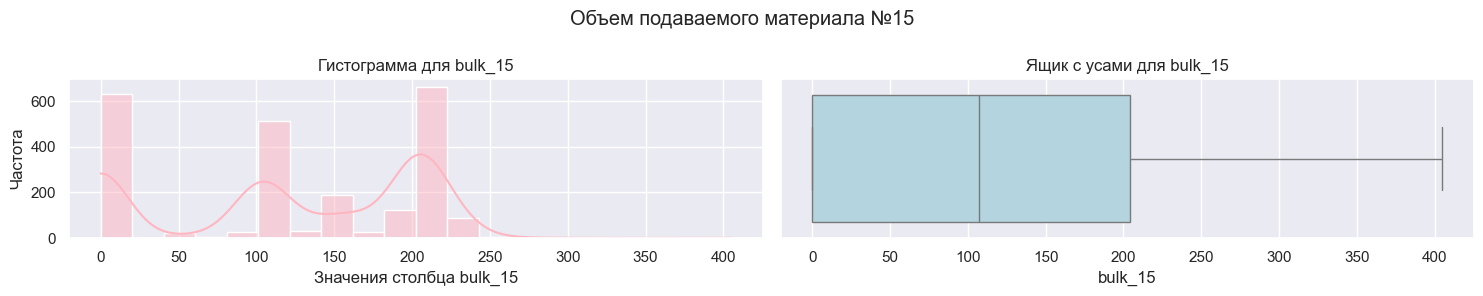

In [304]:
# визуализация признака 'bulk_15'
numeric(data, 'bulk_15', 'Объем подаваемого материала №15')

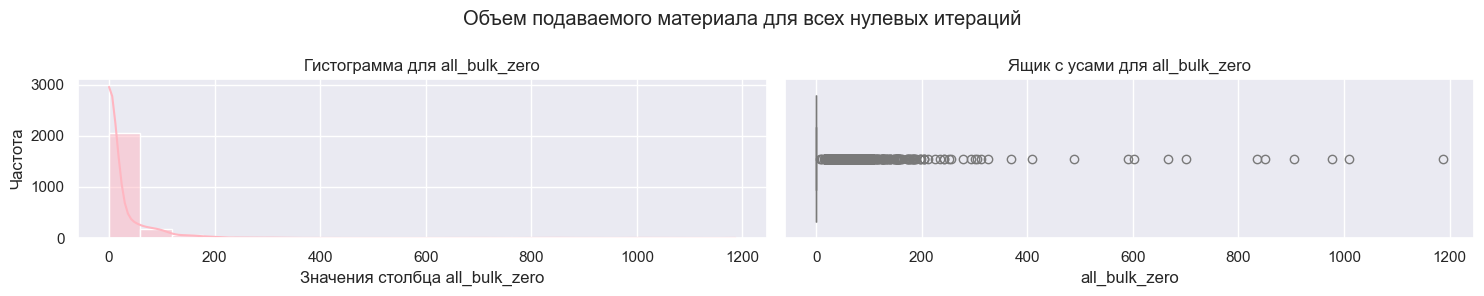

In [305]:
# визуализация признака 'all_bulk_zero'
numeric(data, 'all_bulk_zero', 'Объем подаваемого материала для всех нулевых итераций')

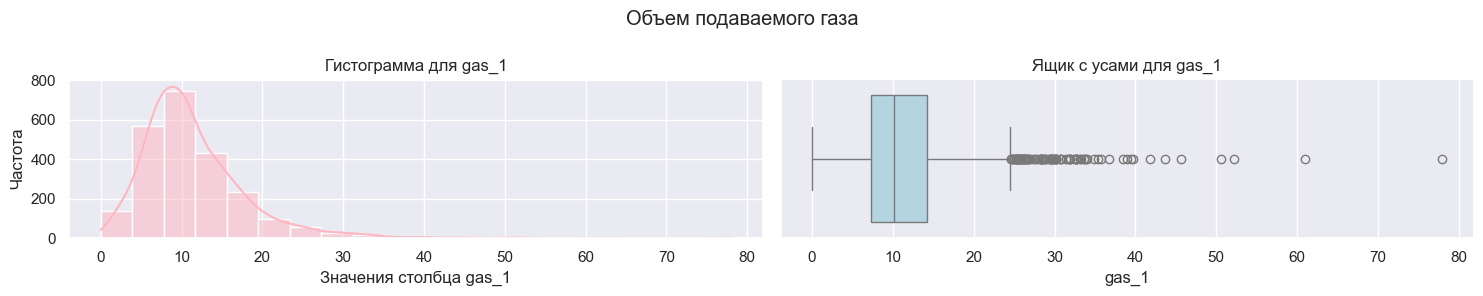

In [306]:
# визуализация признака 'gas_1'
numeric(data, 'gas_1', 'Объем подаваемого газа')

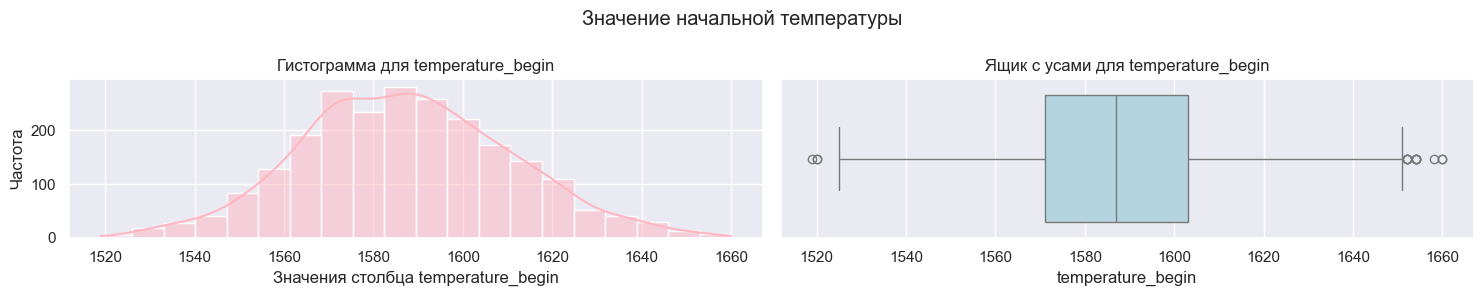

In [307]:
# визуализация признака 'temperature_begin'
numeric(data, 'temperature_begin', 'Значение начальной температуры')

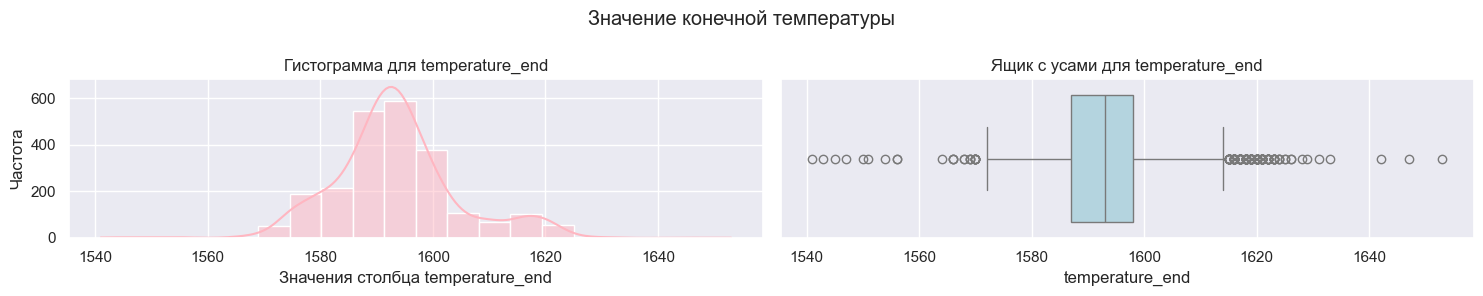

In [308]:
# визуализация признака 'temperature_end'
numeric(data, 'temperature_end', 'Значение конечной температуры')

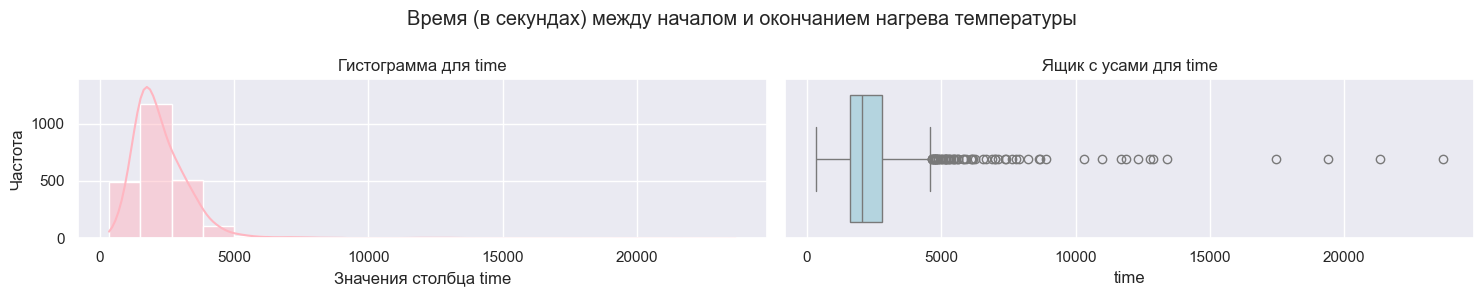

In [309]:
# визуализация признака 'time'
numeric(data, 'time', 'Время (в секундах) между началом и окончанием нагрева температуры')

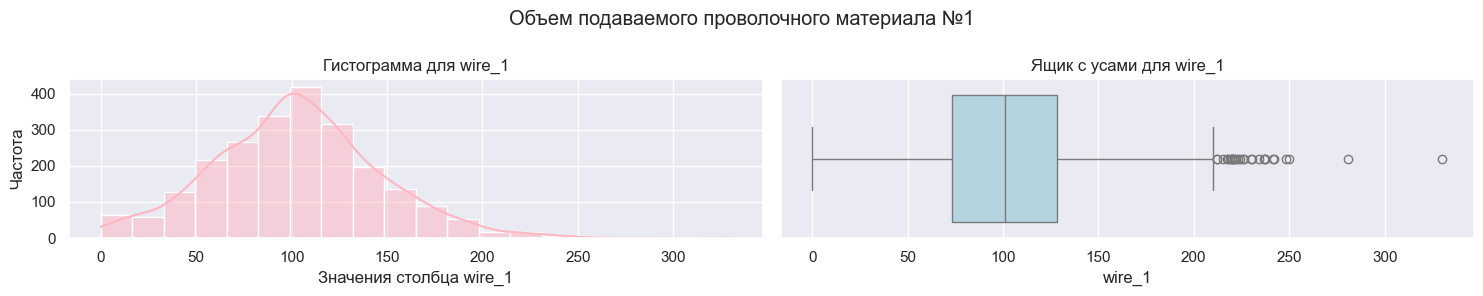

In [310]:
# визуализация признака 'wire_1'
numeric(data, 'wire_1', 'Объем подаваемого проволочного материала №1')

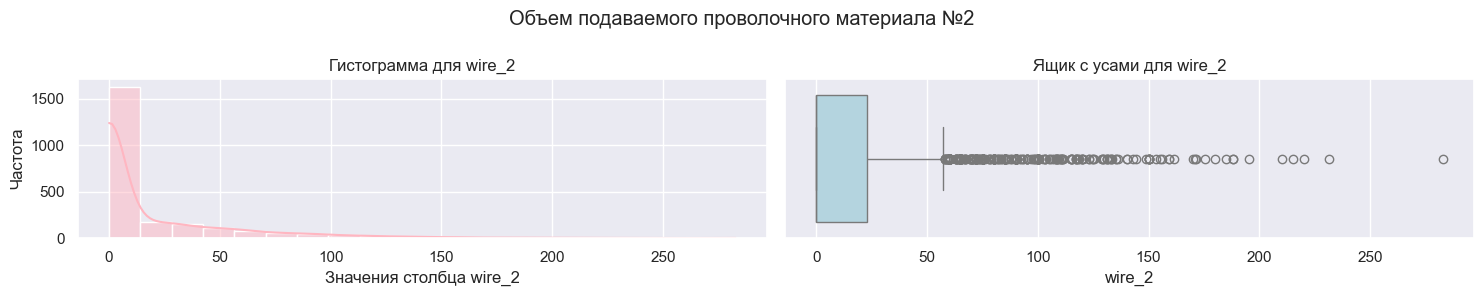

In [311]:
# визуализация признака 'wire_2'
numeric(data, 'wire_2', 'Объем подаваемого проволочного материала №2')

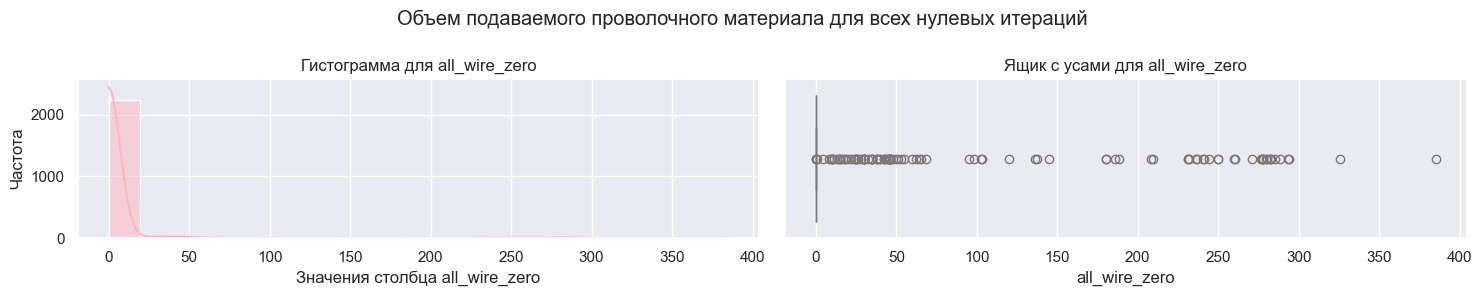

In [312]:
# визуализация признака 'all_wire_zero'
numeric(data, 'all_wire_zero', 'Объем подаваемого проволочного материала для всех нулевых итераций')

**Примечание:** Все признаки нового датафрейма корректно обработаны, присутствуют выбросы, но они не относятся к аномалиям, т.к. являются частью производственного процесса.

### Проведение корреляционного анализа признаков в объединенном датафрейме

In [313]:
# в нашем датафрейме присутствуют только количественное переменные, поэтому не будем объединять их в отдельную переменную
# рассчитаем коэффиценты корреляции для количественных признаков
data.corr()

,power,time_interval,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,all_bulk_zero,gas_1,temperature_begin,temperature_end,time,wire_1,wire_2,all_wire_zero
power,1.000000,0.719234,0.100677,0.004699,0.133724,0.285529,0.298727,0.168286,0.178564,0.370464,-0.152890,0.174833,0.538608,0.138138,0.062337,0.078860
time_interval,0.719234,1.000000,0.091603,-0.029086,0.162777,0.466002,0.461035,0.294538,0.122415,0.396207,-0.383939,0.277953,0.562472,0.055443,0.054460,0.048693
bulk_3,0.100677,0.091603,1.000000,-0.295526,0.066316,0.018059,0.011209,-0.013181,-0.061836,0.059665,-0.113380,-0.037156,0.023019,0.037788,0.094897,0.002012
bulk_4,0.004699,-0.029086,-0.295526,1.000000,-0.251577,0.105190,-0.091103,0.100833,-0.016304,0.017532,0.165484,0.187817,0.002019,0.298145,-0.268115,-0.036390
bulk_6,0.133724,0.162777,0.066316,-0.251577,1.000000,-0.112169,0.176791,-0.108626,0.013693,0.139574,-0.127046,-0.180906,0.154967,-0.235445,0.205432,-0.053995
bulk_12,0.285529,0.466002,0.018059,0.105190,-0.112169,1.000000,0.481609,0.613870,0.000311,0.216969,-0.079574,0.266805,0.209555,0.170812,-0.098208,-0.138637
bulk_14,0.298727,0.461035,0.011209,-0.091103,0.176791,0.481609,1.000000,0.264903,-0.058360,0.268284,-0.179991,0.114893,0.173886,-0.052654,0.037017,-0.031829
bulk_15,0.168286,0.294538,-0.013181,0.100833,-0.108626,0.613870,0.264903,1.000000,-0.096689,0.043033,-0.062382,0.265772,0.099081,0.119047,-0.096411,-0.138829
all_bulk_zero,0.178564,0.122415,-0.061836,-0.016304,0.013693,0.000311,-0.058360,-0.096689,1.000000,0.250345,0.093752,-0.116404,0.299016,-0.121192,-0.022450,0.336856
gas_1,0.370464,0.396207,0.059665,0.017532,0.139574,0.216969,0.268284,0.043033,0.250345,1.000000,0.036736,0.059079,0.439041,0.118192,0.104653,0.155376


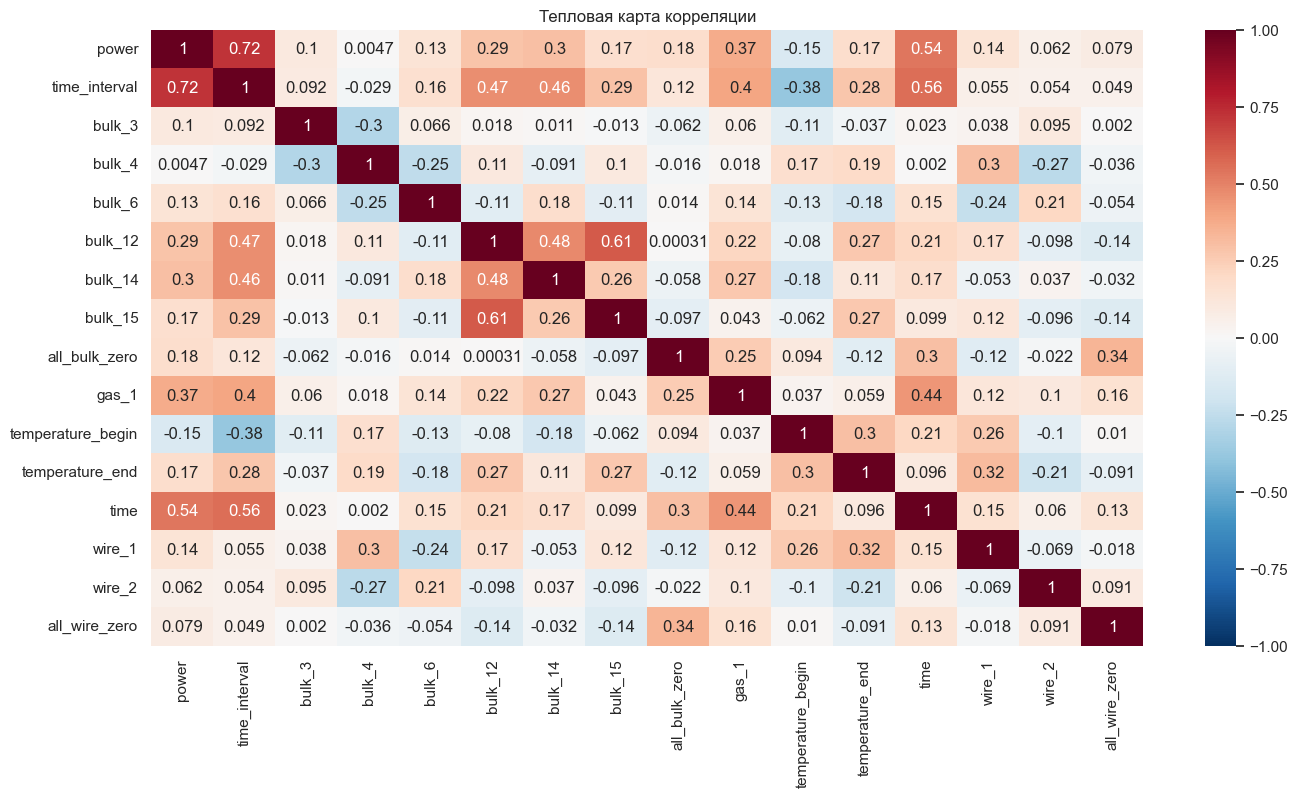

In [314]:
# нарисуем тепловую карту для визуализации результатов полученных коэффициентов корреляции
plt.figure(figsize=(16,8))
sns.heatmap(
    data.corr(),        
    cmap='RdBu_r',
    annot=True, 
    vmin=-1, vmax=1)
plt.title("Тепловая карта корреляции")
plt.show();

**Примечание:** 

**Целевой признак:** 'temperature_end' (значение конечной температуры).
1. Зависимость целевого признака с отстальными достаточно низкая, значения коэффициента корреляции колеблется возле нуля.
2. Связь между признаками 'power' (полная мощность) и 'time_interval' (значение времени (в секундах) между началом и окончанием нагрева) линейная и сильная, это подтверждает полученные коэффициент корреляции, равный 0.72.
3. Мультиколлинеарность между входными признаками не наблюдается.

**Обобщающий вывод этапа "Исследовательский анализ и предобработка данных объединенного датафрейма":**
1. Все признаки нового датафрейма корректно обработаны, присутствуют выбросы, но они не относятся к аномалиям, т.к. являются частью производственного процесса.
2. Зависимость целевого признака ('temperature_end' (значение конечной температуры)) с отстальными достаточно низкая, значения коэффициента корреляции колеблется возле нуля.
3. Связь между признаками 'power' (полная мощность) и 'time_interval' (значение времени (в секундах) между началом и окончанием нагрева) линейная и сильная, это подтверждает полученные коэффициент корреляции, равный 0.72.
4. Мультиколлинеарность между входными признаками не наблюдается.

## Подготовка данных

In [315]:
# разделим сформированный датасет на целевой признак и остальные
X = data.drop('temperature_end', axis=1)
y = data['temperature_end']

In [316]:
# выделяем тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, shuffle=True
)

In [318]:
# проверяем корректность разбиения на выборки
print('Размер тренировочной выборки - {:.0%}'.format(X_train.shape[0] / X.shape[0]))
print('Размер тестовой выборки - {:.0%}'.format(X_test.shape[0] / X.shape[0]))

Размер тренировочной выборки - 75%
Размер тестовой выборки - 25%


In [319]:
print(f"X_train размерность: {X_train.shape}")
print(f"X_test размерность: {X_test.shape}")

X_train размерность: (1743, 15)
X_test размерность: (581, 15)


**Обобщающий вывод этапа "Подготовка данных":** 
1. Данные разбиты на тренировочную и тестовую выборки, 75% и 25% соответственно.
2. Полученные размерности выборок соответствуют действительности.

## Обучение моделей машинного обучения

На данном этапе модели будут обучаться с помощью кросс-валидации, тестовая выборка будет использоваться только один раз при проверке качества лучшей модели.

Будут использоваться следующие модели:
1. LinearRegression (для этой модели будет реализовано масштабирование данных);
2. DecisionTreeRegressor (для этой модели будет реализован подбор гиперпараметров);
3. CatBoostRegressor (для этой модели будут фиксированные параметры);
4. LightGBM (для этой модели будут фиксированные параметры).

In [320]:
# напишем собственную функцию для расчета времени обучения, предсказания и метрики качества МАЕ (с использованием кросс-валидации)
def crossval_evaluate_model(model, X_train, y_train, cv=5):
    # инициализируем метод кросс-валидации для временных рядов
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    mae, train_time, pred_time = [], [], []

    # разделение данных с учетом кросс-валидации
    for train_idx, valid_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # обучение модели и замер времени для этого
        start_train = time.time()
        model.fit(X_tr, y_tr)
        train_time.append(time.time() - start_train)

        # предсказание модели и замер времени для этого
        start_pred = time.time()
        y_pred = model.predict(X_val)
        pred_time.append(time.time() - start_pred)

        # расчет метрики
        mae.append(mean_absolute_error(y_val, y_pred))

    return np.mean(mae), np.mean(train_time), np.mean(pred_time)

In [321]:
# создаем модели 
models = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "CatBoostRegressor": CatBoostRegressor(random_state=RANDOM_STATE, verbose=100),
    "LightGBM": LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)
}

In [322]:
results = []

# запись всех результатов в окончательную таблицу
for name, model in models.items():
    mae_cv, train_time, pred_time = crossval_evaluate_model(model, X_train, y_train, cv=5)
    results.append({
        "Модель": name,
        "MAE (на CV)": mae_cv,
        "Время обучения (с) (на CV)": train_time,
        "Время предсказания (с) (на CV)": pred_time
    })

Learning rate set to 0.043149
0:	learn: 11.2371241	total: 9.88ms	remaining: 9.87s
100:	learn: 7.3652081	total: 590ms	remaining: 5.25s
200:	learn: 6.3980089	total: 1.16s	remaining: 4.61s
300:	learn: 5.6459683	total: 1.75s	remaining: 4.07s
400:	learn: 5.0296419	total: 2.32s	remaining: 3.47s
500:	learn: 4.5096369	total: 2.9s	remaining: 2.88s
600:	learn: 4.0746000	total: 3.52s	remaining: 2.33s
700:	learn: 3.6915369	total: 4.09s	remaining: 1.74s
800:	learn: 3.3695038	total: 4.68s	remaining: 1.16s
900:	learn: 3.0839874	total: 5.34s	remaining: 587ms
999:	learn: 2.8140830	total: 5.93s	remaining: 0us
Learning rate set to 0.043149
0:	learn: 11.0083054	total: 5.31ms	remaining: 5.3s
100:	learn: 7.2618577	total: 563ms	remaining: 5.01s
200:	learn: 6.3137210	total: 1.14s	remaining: 4.53s
300:	learn: 5.4968164	total: 1.75s	remaining: 4.05s
400:	learn: 4.9304774	total: 2.32s	remaining: 3.46s
500:	learn: 4.4823608	total: 2.9s	remaining: 2.89s
600:	learn: 4.0993526	total: 3.47s	remaining: 2.3s
700:	learn

In [323]:
# подберем наилучшие гиперпараметры для модели DecisionTreeRegressor
# составим список параметров
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10]
}

In [324]:
# инициализируем модель
dtr_model = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [325]:
# подбор гиперпараметров
search = RandomizedSearchCV(
    dtr_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=250825),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 10, None],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=250825, scoring='neg_mean_absolute_error')

In [326]:
# оценим найденную модель через собственную функцию
mae_cv, train_time, pred_time = crossval_evaluate_model(search.best_estimator_, X_train, y_train, cv=5)
results.append({
    "Модель": "DecisionTreeRegressor (с гиперпараметрами)",
    "MAE (на CV)": mae_cv,
    "Время обучения (с) (на CV)": train_time,
    "Время предсказания (с) (на CV)": pred_time
})

In [327]:
# выводим результаты в виде таблицы с сортировкой
df_results = pd.DataFrame(results).sort_values(by="MAE (на CV)")
df_results

,Модель,MAE (на CV),Время обучения (с) (на CV),Время предсказания (с) (на CV)
2,CatBoostRegressor,5.891912,6.179065,0.005082
0,LinearRegression,5.936078,0.008943,0.003544
3,LightGBM,5.998182,0.175221,0.006005
4,DecisionTreeRegressor (с гиперпараметрами),7.487175,0.027571,0.002447
1,DecisionTreeRegressor,8.587220,0.041638,0.003226


**Обобщающий вывод этапа "Обучение моделей машинного обучения":**
1. По метрике оценки качества МАЕ, которая по условию задачи должна быть меньше 6.8, лучше всего себя показала модель: CatBoostRegressor.
2. Самой быстрой по сравнению с другими и подходящей по критериям для метрики оценки качества оказалась модель: LinearRegression. Однако результаты ее метрики качества оказали ниже, чем у CatBoostRegressor.
3. Модель DecisionTreeRegressor как с гиперпараметрами, так и без них, показала наихудший результат, не подходящий под критерий от заказчика, по метрике оценки качества МАЕ. Однако стоит отметить, что модель DecisionTreeRegressor (с гиперпараметрами) оказалась самой быстрой по времени обучения и предсказания среди всех рассматриваемых моделей.

## Выбор лучшей модели и проверка ее качества на тестовой выборке

In [328]:
# повторный вывод результата
df_results

,Модель,MAE (на CV),Время обучения (с) (на CV),Время предсказания (с) (на CV)
2,CatBoostRegressor,5.891912,6.179065,0.005082
0,LinearRegression,5.936078,0.008943,0.003544
3,LightGBM,5.998182,0.175221,0.006005
4,DecisionTreeRegressor (с гиперпараметрами),7.487175,0.027571,0.002447
1,DecisionTreeRegressor,8.587220,0.041638,0.003226


**Примечание:** Лучшей моделью по метрике оценки качества МАЕ оказалась CatBoostRegressor (МАЕ = 5.89 на кросс-валидации), она удовлетворяет условию заказчика, что МАЕ должна быть не выше 6.8. Для проверки качества на тестовой выборке будем брать именно ее. Однако стоит отметить, что если бы еще одним условием заказчика была скорость работы модели, а именно время обучения и предсказания, то гланым претендентом была бы модель LinearRegression, которая несильно уступает по метрике качества МАЕ, но операжает модель CatBoostRegressor по скорости.

In [329]:
# выбираем лучшую модель
best_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=100)
best_model.fit(X_train, y_train)

Learning rate set to 0.0447
0:	learn: 11.1008944	total: 7.89ms	remaining: 7.88s
100:	learn: 7.3443419	total: 739ms	remaining: 6.58s
200:	learn: 6.4098728	total: 1.35s	remaining: 5.35s
300:	learn: 5.7032360	total: 1.96s	remaining: 4.54s
400:	learn: 5.1578615	total: 2.55s	remaining: 3.81s
500:	learn: 4.6724183	total: 3.16s	remaining: 3.15s
600:	learn: 4.3061517	total: 3.77s	remaining: 2.5s
700:	learn: 3.9763914	total: 4.32s	remaining: 1.84s
800:	learn: 3.6770109	total: 4.9s	remaining: 1.22s
900:	learn: 3.4470983	total: 5.48s	remaining: 602ms
999:	learn: 3.2137675	total: 6.08s	remaining: 0us


In [330]:
%%time
start_test_pred = time.time()
y_test_pred = best_model.predict(X_test)
test_pred_time = time.time() - start_test_pred

CPU times: total: 46.9 ms
Wall time: 8.33 ms


In [331]:
# расчет МАЕ на тестовой выборке
mae_test = mean_absolute_error(y_test, y_test_pred)

# вывод итоговых результатов
print(f"МАЕ на тестовой выборке: {mae_test:.2f}")
print(f"Время предсказания: {test_pred_time:.4f} секунд")

МАЕ на тестовой выборке: 5.98
Время предсказания: 0.0083 секунд


In [332]:
# проведем сравнение со значением метрики МАЕ константной модели
# обучаем DummyRegressor 
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

# проводим предсказание на тестовой выборке
y_pred_dummy = dummy.predict(X_test)

# считаем метрику-качества MAE на константной модели
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

print(f"MAE DummyRegressor (константной модели): {mae_dummy:.4f}")

MAE DummyRegressor (константной модели): 7.7806


**Примечание:** Полученная метрика оценки качества МАЕ на модели CatBoostRegressor(random_state=RANDOM_STATE, verbose=100) составила 5.98, что является меньше, чем значение МАЕ, равное 7.78, на константной модели (DummyRegressor), а это значит, что модель реально обучается и является полезной.

In [333]:
# получаем SHAP-значения 
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

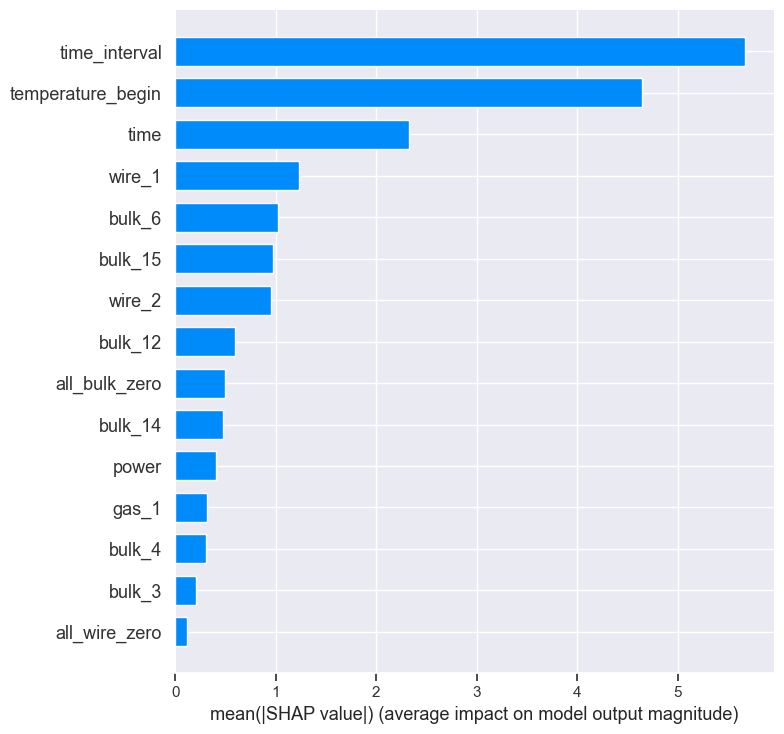

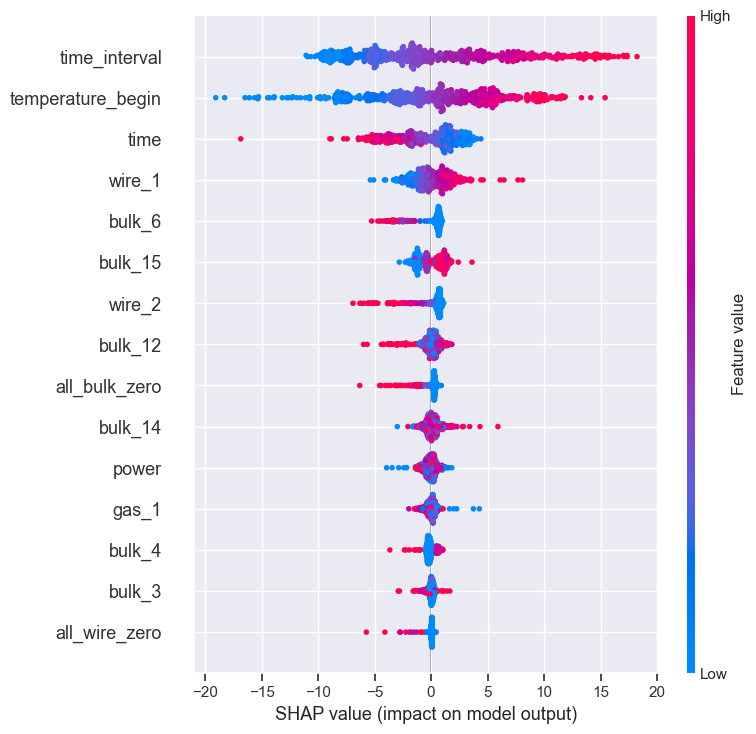

In [334]:
# строим графики важности признаков
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test) 

**Примечание:** Наибольшим весом для модели обладают признаки: 'time_interval' (значение времени (в секундах) между началом и окончанием нагрева), 'temperature_begin' (начальная температура), 'time' (время (в секундах) между началом и окончанием нагрева температуры). Сильную связь признаков 'time_interval' и 'temperature_begin' с целевым признаком ('temperature_end') можно объяснить тем, что они являются частью единого процесса нагрева стали.

**Обобщающий вывод этапа "Выбор лучшей модели и проверка ее качества на тестовой выборке":**
1. Лучшей моделью по метрике оценки качества МАЕ оказалась CatBoostRegressor (МАЕ = 5.89 на кросс-валидации), она удовлетворяет условию заказчика, что МАЕ должна быть не выше 6.8. Значение метрики качества МАЕ модели на **тестовой выборке** составило 5.98.
2. Наибольшим весом для модели обладают признаки: 'time_interval' (значение времени (в секундах) между началом и окончанием нагрева), 'temperature_begin' (начальная температура), 'time' (время (в секундах) между началом и окончанием нагрева температуры). Сильную связь признаков 'time_interval' и 'temperature_begin' с целевым признаком ('temperature_end') можно объяснить тем, что они являются частью единого процесса нагрева стали.

## Формирование обших выводов и рекомендаций для заказчика

В ходе работы были проанализированы данные, предоставленные металлургическим комбинатом «Стальная птица», который хочет разработать модель, позволяющую определить конечную температуру сплава.

Для реализации этой задачи было выполнено 7 этапов работы.

На **1 этапе: Загрузка и изучение данных** были проанализированы все исходные данные, которые хранятся в 7 файлах, и выделены следующие наблюдения:
1. Данные во всех семи таблицах соответствую описанию задачи.
2. В пяти из семитаблицах с данными в столбцах присутствуют пропуски, некоторые из которых необходимо обработать. Также в некоторых таблицах необходимо изменить тип данных некоторых столбцов.
3. Во всех таблицах необходимо привести названия столбцов к общепринятому "змеиному" стилю.
4. Также стоит отметить, что при первичном изучении данных было выяснено, что таблицы 'data_bulk_time_new' и 'data_wire_time_new' содержать информацию о времени подачи различных видов материалов. Эти данные не имеют ценности для дальнейшего анализа. Поэтому уже на первом этапе эти таблицы с данными будут отброшены и не будут использоваться при дальнейшей обработке и реализации проекта, что в том числе сократит время выполнения задачи.

На **2 этапе: Исследовательский анализ и предобработка данных** дктально были изучены 5 таблиц, а именно:
1. data_arc_new — данные об электродах;
2. data_bulk_new — данные о подаче сыпучих материалов (объём);
3. data_gas_new — данные о продувке сплава газом;
4. data_temp_new — результаты измерения температуры;
5. data_wire_new — данные о проволочных материалах (объём);

Две таблицы 'data_bulk_time_new — данные о подаче сыпучих материалов (время)' и 'data_wire_time_new — данные о проволочных материалах (время)' на следующих этапах участвовать не будут, т.к. были откинуты с точки зрения неинформативности для реализации задачи.

И сделаны следующие выводы:
1. Названия во всех таблицах приведены к общепринятому "змеиному" стилю.
2. Во всех таблицах отсутствуют явные дубликаты.
3. Пропуски в таблицах 'data_bulk_new' и 'data_wire_new' заполнены нулями.
4. В таблицах 'data_arc_new' и 'data_temp_new' обработаны аномалии в столбцах 'reactive_power' (реактивная мощность) и 'temperature_begin' (начальная температура) соответственно.
5. Рассчитаны новые признаки: 'power' (полная мощность, включающая в себя активную и реактивную мощности), 'time_interval' (время в секундах между началом и окончанием нагрева), 'all_bulk_zero' (столбец со значениями всех нулевых итераций по подаче материалов), 'temperature_begin' и 'temperature_end' (начальная и конечная температуры соответственно), 'time' (время в секундах между началом и окончанием нагрева температуры), 'all_wire_zero' (столбец со значениями всех нулевых итераций по подаче проволочных материалов).

На **3 этапе: Объединение данных** было реализовано следующее:
1. На данном этапе все 5 таблиц после предобработки были объединены в одну общую таблицу.
2. Также были удалены столбцы, которые не являются информативными для исследования, а именно вся необходимая инфрмация из них содержится в других столбцах.
3. Пропуски и явные дубликаты в полученной таблице отсутствуют.

На **4 этапе: Исследовательский анализ и предобработка данных объединенного датафрейма** были получены следующие результаты:
1. Все признаки нового датафрейма корректно обработаны, присутствуют выбросы, но они не относятся к аномалиям, т.к. являются частью производственного процесса.
2. Зависимость целевого признака ('temperature_end' (значение конечной температуры)) с отстальными достаточно низкая, значения коэффициента корреляции колеблется возле нуля.
3. Связь между признаками 'power' (полная мощность) и 'time_interval' (значение времени (в секундах) между началом и окончанием нагрева) линейная и сильная, это подтверждает полученные коэффициент корреляции, равный 0.72.
4. Мультиколлинеарность между входными признаками не наблюдается.

На **5 этапе: Подготовка данных** было реализовано следующее:
1. 1. Данные разбиты на тренировочную и тестовую выборки, 75% и 25% соответственно.
2. Полученные размерности выборок соответствуют действительности.

На **6 этапе: Обучение моделей машинного обучения** было рассмотрено:

На данном этапе модели будут обучаться с помощью тренировочной и валидационной выборок, тестовая выборка будет использоваться только один раз при проверке качества лучшей модели.

Будут использоваться следующие модели:
1. LinearRegression (для этой модели будет реализовано масштабирование данных);
2. DecisionTreeRegressor (для этой модели будет реализован подбор гиперпараметров);
3. CatBoostRegressor (для этой модели будут фиксированные параметры);
4. LightGBM (для этой модели будут фиксированные параметры).

И получены следующие результаты:
1. По метрике оценки качества МАЕ, которая по условию задачи должна быть меньше 6.8, лучше всего себя показала модель: CatBoostRegressor.
2. Самой быстрой по сравнению с другими и подходящей по критериям для метрики оценки качества оказалась модель: LinearRegression. Однако результаты ее метрики качества оказали ниже, чем у CatBoostRegressor.
3. Модель DecisionTreeRegressor как с гиперпараметрами, так и без них, показала наихудший результат, не подходящий под критерий от заказчика, по метрике оценки качества МАЕ. Однако стоит отметить, что модель DecisionTreeRegressor (с гиперпараметрами) оказалась самой быстрой по времени обучения и предсказания среди всех рассматриваемых моделей.

На **7 этапе: Выбор лучшей модели и проверка ее качества на тестовой выборке** были сделаны выводы о том, что:
1. Лучшей моделью по метрике оценки качества МАЕ оказалась CatBoostRegressor (МАЕ = 5.89 на кросс-валидации), она удовлетворяет условию заказчика, что МАЕ должна быть не выше 6.8. Значение метрики качества МАЕ модели на **тестовой выборке** составило 5.98.
2. Наибольшим весом для модели обладают признаки: 'time_interval' (значение времени (в секундах) между началом и окончанием нагрева), 'temperature_begin' (начальная температура), 'time' (время (в секундах) между началом и окончанием нагрева температуры). Сильную связь признаков 'time_interval' и 'temperature_begin' с целевым признаком ('temperature_end') можно объяснить тем, что они являются частью единого процесса нагрева стали.

**Таким образом,** анализируя всю полученную в ходе исследования информацию, можно сделать вывод, что наилучшей моделью для предсказания конечной температуры сплава является CatBoostRegressor (с результатами МАЕ = 5.98 на тестовой выборке), так как заказчику важно, чтобы метрика оценки качества МАЕ была **не выше 6.8.**